## Create own word embeddings using  word2vec and glove

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import gzip
import keras

Using TensorFlow backend.


In [3]:
import nltk
from nltk import numpy
from nltk import ne_chunk, pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize, PunktSentenceTokenizer
from nltk.corpus import stopwords
import gensim.models.word2vec as w2v
from gensim import logging
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as  pd
import seaborn as sns
import pickle

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Handle multiword

In [6]:
s='Airport Suite Bangkok Muang located area city Don Mueang hotel good also near Don Mueang International Airport km plenty tourist attractions IT Square within Central Ramintra'

In [7]:
from nltk.tokenize import MWETokenizer
from nltk import sent_tokenize, word_tokenize

In [8]:
mwe = MWETokenizer([('New', 'York'), ('Hong', 'Kong'), 
                    ('IT', 'Square'), ('Airport','Suite','Bangkok'),
                    ('International','Airport'),
                    ('Central', 'Ramintra'), ('Kasetsart','University'),
                    ('Don','Mueang'),('Emerald', 'Buddha')], separator='_')

In [9]:
[mwe.tokenize(word_tokenize(sent)) for sent in sent_tokenize(s)]

[['Airport_Suite_Bangkok',
  'Muang',
  'located',
  'area',
  'city',
  'Don_Mueang',
  'hotel',
  'good',
  'also',
  'near',
  'Don_Mueang',
  'International_Airport',
  'km',
  'plenty',
  'tourist',
  'attractions',
  'IT_Square',
  'within',
  'Central_Ramintra']]

### Read file multiword

Assume some data set is under keywords directory.


In [242]:
#word_file = 'words.txt'
#word_file = 'allword.txt'
word_files = ['keywords/list_location.txt', 'keywords/facility.txt' , 'keywords/nearby.txt','keywords/list_hotel.txt']
word_list = []
count = 0
for word_file in word_files:
    with open(word_file) as f:
        lines = f.readlines()
    word_list2 = [x.strip().lower() for x in lines] 
    count += len(word_list2)
    word_list.extend(word_list2)
    print(word_file,count)
word_list[:5]

keywords/list_location.txt 17660
keywords/facility.txt 17918
nearby.txt 18822
keywords/list_hotel.txt 41169


['99/89 moo 6',
 'viphavadee randsit rd',
 '111/1 soi ngam wong wan 47 yaek 1',
 '310/72 soi phaholyothin 67/1',
 '3/2899 soi yak']

In [243]:
#remove duplicates
def ordered_set(in_list):
    out_list = []
    added = set()
    for val in in_list:
        if not val in added:
            out_list.append(val)
            added.add(val)
    return out_list

In [244]:
len(word_list)

41169

In [245]:
word_list = ordered_set(word_list)

In [246]:
len(word_list)

37108

In [248]:
mw_list = []
for x in word_list:
    ws = x.split() 
    if len(ws) > 1:
        
        tws = tuple(ws)
        mw_list.append(tws)
        if ws[0] == 'platinum':
            print(tws)
mw_list[:5]

('platinum', 'fashion', 'mall')
('platinum', 'restaurant', 'lounge', 'novotel', 'bangkok', 'platinum', 'pratunam')
('platinum', 'residence', '10')
('platinum', 'villa', 'by', 'pro-phuket', '(a)')
('platinum', 'villa', 'by', 'pro-phuket')
('platinum', 'pool', 'villa', 'at', 'rawai', 'by', 'pro-phuket')
('platinum', 'villa', 'by', 'pro-phuket', '(b)')
('platinum', 'villa')
('platinum', '3', 'bedrooms', 'villa', 'pool', 'garden')
('platinum', 'hotel')
('platinum', 'place', 'hotel')
('platinum', 'villa', 'hotel')


[('99/89', 'moo', '6'),
 ('viphavadee', 'randsit', 'rd'),
 ('111/1', 'soi', 'ngam', 'wong', 'wan', '47', 'yaek', '1'),
 ('310/72', 'soi', 'phaholyothin', '67/1'),
 ('3/2899', 'soi', 'yak')]

In [239]:
for i in mw_list:
    if i == ('kasetsart','university'):
        print('found')
    if i == ('platinum','villa'):
        print ('found2')
    if i == ('platinum','villa','by','pro','phuket'):
        print('found3')

found
found2


In [93]:
mwe = MWETokenizer(mw_list,separator=' ')

In [94]:
s='Airport Suite Bangkok  located area city Don Mueang hotel good also near Don Mueang International Airport km plenty tourist attractions IT Square within Central Ramintra'

In [95]:
[mwe.tokenize(word_tokenize(sent)) for sent in sent_tokenize(s.lower())]

[['airport',
  'suite',
  'bangkok',
  'located',
  'area',
  'city',
  'don mueang',
  'hotel',
  'good',
  'also',
  'near',
  'don mueang international airport',
  'km',
  'plenty',
  'tourist',
  'attractions',
  'it square',
  'within',
  'central',
  'ramintra']]

## Contraction list

In [96]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you 'll": "you will",
"you're": "you are",
 "km" : "kilometers",
    "mi" : "miles"
}

#### Download corpus

In [47]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chantana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chantana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Load document files into memory for creating representation

In [48]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	#with codecs.open(filename, "r",encoding='utf-8', errors='ignore') as fdata:
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text 

#### Load own vocabulary

In [50]:
# load the vocabulary
vocab_filename = './embedding/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

#### Clean documents

In [51]:
def select_text (data,keys):
    tokens_list = []
    for item in data:
        for i in keys:
            d = item[i] 
            d = d.encode("utf8") 
            tokens = clean_doc(d, vocab)    
             
            tokens_list.append(str(tokens))
     
    return tokens_list

In [52]:
import re
import string
# turn a doc into clean tokens

regnumber = re.compile(r'^\d+(?:[,.]\d*)?$')
alpha = r'[a-zA-Z]+'
number = r'[-+]?[0-9]*(\.|:)?[0-9]+'
def clean_doc(doc, vocab):
    # split into tokens by white space
    ##tokens = doc.split()
    # remove punctuation from each token
    #table = string.maketrans('', '', punctuaion)
    #tokens = [w.translate(table) for w in tokens]
    
    # We are not using "text.split()" here
    #since it is not fool proof, e.g. words followed by punctuations "Are you kidding?I think you aren't."
    #text = re.findall(r"[a-zA-Z]+", doc) #[-+]?[0-9]*\.?[0-9]+
    #text = re.findall(r"([a-zA-Z\'']+|[-+]?[0-9]*\.?[0-9]+)", doc)
    
    text = re.findall(r"[a-zA-Z\'']+",doc)
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
             
        else:

            new_text.append(word)
    #new_text = [w for w in new_text if w in vocab]
    text = " ".join(new_text)
    text = re.sub(r'[_"\-;%()|+&=*%!:#$@\[\]/]', ' ', text) #skip ".,?"
    text = re.sub(r'\'', ' ', text)
    return text
                      
    #for w in tokens:         
    #    w =  re.sub('['+string.punctuation+']', '', w )       
    # filter out tokens not in vocab
    
    #tokens = [w for w in tokens if w in vocab]
    #tokens = ' '.join(tokens)
     
    #return tokens
 

In [53]:
import json
from os import listdir
# load all docs in a directory
def process_docs(directory, vocab, is_trian):
	documents = []
	# walk through all files in the folder
	for filename in listdir(directory):
	    # create the full path of the file to open
	    path = directory + '/' + filename
	    # load the doc
	    #doc = load_doc(path)
	    with open(path, "r") as f:
	 	     doc = json.load(f)
	    #tokens_list = select_text (doc ,['description','facility','nearby'])
	    # clean doc
	    tokens_list = select_text (doc ,['description']) 
	    #tokens = clean_doc(doc[, vocab)
	    # add to list
	    documents.extend(tokens_list)
        #print(tokens_list[:5])
	return documents

### Start processing documents

In [97]:
# load all training text
hotel_docs = process_docs('./embedding/data', vocab, True)
hotel_docs[:5]

['With a stay at Petpimarn Boutique Resort in Bangkok Chatuchak you will be within a minute drive of Kasetsart University and IMPACT Arena This hotel is miles kilometers from Temple of the Emerald Buddha and miles kilometers from Wat Arun Make yourself at home in one of the air conditioned rooms featuring refrigerators Complimentary wireless Internet access keeps you connected and digital programming is available for your entertainment Bathrooms have showers and complimentary toiletries Conveniences include desks and complimentary bottled water and housekeeping is provided daily Make use of convenient amenities which include complimentary wireless Internet access and tour ticket assistance At Petpimarn Boutique Resort enjoy a satisfying meal at the restaurant English breakfasts are available daily from AM to AM for a fee Featured amenities include dry cleaning laundry services a hour front desk and luggage storage Free self parking is available onsite',
 'Airport Suite Bangkok Don Muan

In [98]:
corpus_raw = "" 
for item in hotel_docs:
    #print("Reading '{0}' ...".format(item))
    #with codecs.open(book_filename, "r", "utf-8") as book_file:
    corpus_raw += item+" "
    #print("Corpus is now {0} characters long" .format(len(corpus_raw)))
    #print()
print("Corpus is now {0} characters long" .format(len(corpus_raw)))
print(corpus_raw[:100])


Corpus is now 5660796 characters long
With a stay at Petpimarn Boutique Resort in Bangkok Chatuchak you will be within a minute drive of K


### Using multiword tokenizer

In [99]:

word_list = [mwe.tokenize(word_tokenize(sent)) for sent in sent_tokenize(corpus_raw.decode('utf-8').lower())]

In [100]:
print(len(word_list))

1


In [101]:
 
word_list[0][:25]

[u'with',
 u'a',
 u'stay',
 u'at',
 u'petpimarn boutique resort',
 u'in',
 u'bangkok',
 u'chatuchak',
 u'you',
 u'will',
 u'be',
 u'within',
 u'a',
 u'minute',
 u'drive',
 u'of',
 u'kasetsart university',
 u'and',
 u'impact arena',
 u'this',
 u'hotel',
 u'is',
 u'miles',
 u'kilometers',
 u'from']

### From here skip to Create Model from here if use your own tokens.

#### Load English token punctuation

In [59]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [68]:
raw_sentences = tokenizer.tokenize(corpus_raw.decode('utf-8').lower())
raw_sentences
 

[u'with a stay at petpimarn boutique resort in bangkok chatuchak you will be within a minute drive of kasetsart university and impact arena this hotel is miles kilometers from temple of the emerald buddha and miles kilometers from wat arun make yourself at home in one of the air conditioned rooms featuring refrigerators complimentary wireless internet access keeps you connected and digital programming is available for your entertainment bathrooms have showers and complimentary toiletries conveniences include desks and complimentary bottled water and housekeeping is provided daily make use of convenient amenities which include complimentary wireless internet access and tour ticket assistance at petpimarn boutique resort enjoy a satisfying meal at the restaurant english breakfasts are available daily from am to am for a fee featured amenities include dry cleaning laundry services a hour front desk and luggage storage free self parking is available onsite airport suite bangkok don muang a

In [69]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-z]"," ", raw)
    words = clean.split()
    return words

## Chop sentences to in to word list

In [65]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence)>0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [66]:
print(raw_sentences[0][:100])
print(sentence_to_wordlist(raw_sentences[0][:100]))

with a stay at petpimarn boutique resort in bangkok chatuchak you will be within a minute drive of k
[u'with', u'a', u'stay', u'at', u'petpimarn', u'boutique', u'resort', u'in', u'bangkok', u'chatuchak', u'you', u'will', u'be', u'within', u'a', u'minute', u'drive', u'of', u'k']


In [67]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 962,007 tokens


In [38]:
sentences[0][:50]

[u'With',
 u'a',
 u'stay',
 u'at',
 u'Petpimarn',
 u'Boutique',
 u'Resort',
 u'in',
 u'Bangkok',
 u'Chatuchak',
 u'you',
 u'll',
 u'be',
 u'within',
 u'a',
 u'minute',
 u'drive',
 u'of',
 u'Kasetsart',
 u'University',
 u'and',
 u'IMPACT',
 u'Arena']

# Create google wiki data model

In [74]:
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.models.word2vec import Word2Vec, LineSentence
from pprint import pprint
from copy import deepcopy
from multiprocessing import cpu_count
from smart_open import smart_open

%%bash
wget https://dumps.wikimedia.org/archive/2010/2010-11/enwiki/20101011/enwiki-20101011-pages-articles.xml.bz2
wget  https://dumps.wikimedia.org/enwiki/20190220/enwiki-20190220-pages-articles8.xml-p1268693p1791079.bz2

In [75]:
old, new = [WikiCorpus('enwiki-{}-pages-articles.xml.bz2'.format(ymd)) for ymd in ['20101011', '20190220']]

Process InputQueue-4:
Traceback (most recent call last):
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib64/python2.7/site-packages/gensim/utils.py", line 1218, in run
    wrapped_chunk = [list(chunk)]
  File "/usr/lib64/python2.7/site-packages/gensim/corpora/wikicorpus.py", line 676, in <genexpr>
    ((text, self.lemmatize, title, pageid, tokenization_params)
  File "/usr/lib64/python2.7/site-packages/gensim/corpora/wikicorpus.py", line 430, in extract_pages
    ns = elem.find(ns_path).text
AttributeError: 'NoneType' object has no attribute 'text'
2019-03-16 10:13:00,070 : WARNING : user terminated iteration over Wikipedia corpus after 0 documents with 0 positions (total 0 articles, 0 positions before pruning articles shorter than 50 words)
2019-03-16 10:13:00,123 : INFO : built Dictionary(0 unique tokens: []) from 0 documents (total 0 corpus positions)


IOError: [Errno 2] No such file or directory: 'enwiki-20190220-pages-articles.xml.bz2'

In [ ]:
def write_wiki(wiki, name, titles = []):
    with smart_open('{}.wiki'.format(name), 'wb') as f:
        wiki.metadata = True
        for text, (page_id, title) in wiki.get_texts():
            if title not in titles:
                f.write(b' '.join(text)+b'\n')
                titles.append(title)
    return titles


In [ ]:
old_titles = write_wiki(old, 'old')
all_titles = write_wiki(new, 'new', old_titles)

In [ ]:
oldwiki, newwiki = [LineSentence(f+'.wiki') for f in ['old', 'new']]

In [ ]:
#Initial training
%%time
wiki_model = Word2Vec(oldwiki, min_count = 0, workers=cpu_count())
# model = Word2Vec.load('oldmodel')
oldmodel = deepcopy(wiki_model)
oldmodel.save('wiki_oldmodel')

In [ ]:

try:
    print(oldmodel.most_similar('babymetal'))
except KeyError as e:
    print(e)

%%time
wiki_model.build_vocab(newwiki, update=True)
wiki_model.train(newwiki, total_examples=model.corpus_count, epochs=model.iter)
wiki_model.save('wiki_newmodel')
#model = load('newmodel')

In [ ]:
try:
    pprint(model.most_similar('babymetal'))
except KeyError as e:
    print(e)

In [ ]:
w = 'zootopia'
for m in ['oldmodel', 'model']:
    print('The count of the word,'+w+', is', eval(m).wv.vocab[w].count, 'in', m)
    pprint(eval(m).most_similar(w))
    print('')

## Create model

In [191]:
hotel2vec = w2v.Word2Vec(
    sg=1,
    seed=1,
    workers=multiprocessing.cpu_count(),
    size=50, # equal to glove 50d
    min_count=7,
    window=7, #win = 7
    sample=1e-3
)

2019-03-16 11:50:27,745 : WARNING : consider setting layer size to a multiple of 4 for greater performance


In [192]:
sentences = word_list ## here use multiword token. IF not, skip this.
sentences[:5]

[[u'with',
  u'a',
  u'stay',
  u'at',
  u'petpimarn boutique resort',
  u'in',
  u'bangkok',
  u'chatuchak',
  u'you',
  u'will',
  u'be',
  u'within',
  u'a',
  u'minute',
  u'drive',
  u'of',
  u'kasetsart university',
  u'and',
  u'impact arena',
  u'this',
  u'hotel',
  u'is',
  u'miles',
  u'kilometers',
  u'from',
  u'temple',
  u'of',
  u'the',
  u'emerald buddha',
  u'and',
  u'miles',
  u'kilometers',
  u'from',
  u'wat arun',
  u'make',
  u'yourself',
  u'at',
  u'home',
  u'in',
  u'one',
  u'of',
  u'the',
  u'air',
  u'conditioned',
  u'rooms',
  u'featuring',
  u'refrigerators',
  u'complimentary',
  u'wireless',
  u'internet',
  u'access',
  u'keeps',
  u'you',
  u'connected',
  u'and',
  u'digital',
  u'programming',
  u'is',
  u'available',
  u'for',
  u'your',
  u'entertainment',
  u'bathrooms',
  u'have',
  u'showers',
  u'and',
  u'complimentary',
  u'toiletries',
  u'conveniences',
  u'include',
  u'desks',
  u'and',
  u'complimentary',
  u'bottled',
  u'water',
 

In [193]:
hotel2vec.build_vocab(sentences)

2019-03-16 11:50:31,914 : INFO : collecting all words and their counts
2019-03-16 11:50:31,915 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-16 11:50:32,083 : INFO : collected 7548 word types from a corpus of 873682 raw words and 1 sentences
2019-03-16 11:50:32,084 : INFO : Loading a fresh vocabulary
2019-03-16 11:50:32,125 : INFO : effective_min_count=7 retains 2818 unique words (37% of original 7548, drops 4730)
2019-03-16 11:50:32,126 : INFO : effective_min_count=7 leaves 856721 word corpus (98% of original 873682, drops 16961)
2019-03-16 11:50:32,134 : INFO : deleting the raw counts dictionary of 7548 items
2019-03-16 11:50:32,136 : INFO : sample=0.001 downsamples 90 most-common words
2019-03-16 11:50:32,137 : INFO : downsampling leaves estimated 536329 word corpus (62.6% of prior 856721)
2019-03-16 11:50:32,146 : INFO : estimated required memory for 2818 words and 50 dimensions: 2536200 bytes
2019-03-16 11:50:32,147 : INFO : resetting layer wei

In [195]:
total_examples = hotel2vec.corpus_count
total_examples

1

In [196]:
print(len(hotel2vec.wv.vocab))

2818


In [197]:
len(sentences[0])

873682

In [198]:
print (sentences[0][:10])

[u'with', u'a', u'stay', u'at', u'petpimarn boutique resort', u'in', u'bangkok', u'chatuchak', u'you', u'will']


In [199]:
from gensim.models import KeyedVectors

## Load pretrained model

In [84]:
model_gg =  KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

2019-03-16 10:15:48,364 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2019-03-16 10:17:25,493 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


In [85]:
model_1 = KeyedVectors.load_word2vec_format("glove.6B.50d-1.txt", binary=False)

model_1_300 = KeyedVectors.load_word2vec_format("glove.6B.300d-1.txt", binary=False)
model_num = KeyedVectors.load_word2vec_format("numberbatch-en-17.02.txt", binary=False)


2019-03-16 10:17:48,348 : INFO : loading projection weights from glove.6B.50d-1.txt
2019-03-16 10:18:10,067 : INFO : loaded (400000, 50) matrix from glove.6B.50d-1.txt
2019-03-16 10:18:10,069 : INFO : loading projection weights from glove.6B.300d-1.txt
2019-03-16 10:19:53,705 : INFO : loaded (400000, 300) matrix from glove.6B.300d-1.txt
2019-03-16 10:19:53,707 : INFO : loading projection weights from numberbatch-en-17.02.txt
2019-03-16 10:21:55,678 : INFO : loaded (484556, 300) matrix from numberbatch-en-17.02.txt


In [494]:
#fname =  'glove.6B.50d.w2v'
#model_1.wv.save_word2vec_format(os.path.join("trained", fname))

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
2019-03-06 14:44:48,163 : INFO : storing 400000x50 projection weights into trained/glove.6B.50d.w2v


#dumpy as pickle
df = pd.read_csv('glove.6B.50d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in df.T.items()}
import pickle
with open('trained/glove.6B.50d.pkl', 'wb') as fp:
    pickle.dump(glove, fp)
    

fname =  'glove.6B.50d.pkl'
word2vec_pre = load(os.path.join("trained", fname))




In [133]:
print('glove-50',len(model_1.vocab.keys()))
print('glove-300',len(model_1_300.vocab.keys()))
print('numberbatch-en-17.02.txt',len(model_num.vocab.keys()))
print('google',len(model_gg.vocab.keys()))

glove-50 400000
glove-300 400000
numberbatch-en-17.02.txt 484556
google 3000000


In [134]:
vocab_gg = model_gg.vocab.keys()
wordsInVocab = len(vocab_gg)
print(len(model_gg.wv['spa']))
print (wordsInVocab)
print (model_gg.similarity('this', 'is'))
print (model_gg.similarity('post', 'book'))


300
3000000
0.40797037
0.057204384


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [200]:
hotel2vec_1 = w2v.Word2Vec(
    sg=1,
    seed=1,
    workers=multiprocessing.cpu_count(),
    size=50, # equal to glove 50d
    min_count=7,
    window=7, #win = 7
    sample=1e-3
)
hotel2vec_1.build_vocab(sentences)

2019-03-16 11:51:37,417 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-03-16 11:51:37,609 : INFO : collecting all words and their counts
2019-03-16 11:51:37,610 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-16 11:51:37,797 : INFO : collected 7548 word types from a corpus of 873682 raw words and 1 sentences
2019-03-16 11:51:37,798 : INFO : Loading a fresh vocabulary
2019-03-16 11:51:37,808 : INFO : effective_min_count=7 retains 2818 unique words (37% of original 7548, drops 4730)
2019-03-16 11:51:37,811 : INFO : effective_min_count=7 leaves 856721 word corpus (98% of original 873682, drops 16961)
2019-03-16 11:51:37,822 : INFO : deleting the raw counts dictionary of 7548 items
2019-03-16 11:51:37,825 : INFO : sample=0.001 downsamples 90 most-common words
2019-03-16 11:51:37,832 : INFO : downsampling leaves estimated 536329 word corpus (62.6% of prior 856721)
2019-03-16 11:51:37,843 : INFO : estimated required 

In [209]:
hotel2vec_2 = w2v.Word2Vec(
    sg=1,
    seed=1,
    workers=multiprocessing.cpu_count(),
    size=300, # equal to glove 50d
    min_count=7,
    window=7, #win = 7
    sample=1e-3
)
hotel2vec_2.build_vocab(sentences)

2019-03-16 12:00:37,923 : INFO : collecting all words and their counts
2019-03-16 12:00:37,923 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-16 12:00:38,116 : INFO : collected 7548 word types from a corpus of 873682 raw words and 1 sentences
2019-03-16 12:00:38,118 : INFO : Loading a fresh vocabulary
2019-03-16 12:00:38,132 : INFO : effective_min_count=7 retains 2818 unique words (37% of original 7548, drops 4730)
2019-03-16 12:00:38,138 : INFO : effective_min_count=7 leaves 856721 word corpus (98% of original 873682, drops 16961)
2019-03-16 12:00:38,149 : INFO : deleting the raw counts dictionary of 7548 items
2019-03-16 12:00:38,154 : INFO : sample=0.001 downsamples 90 most-common words
2019-03-16 12:00:38,157 : INFO : downsampling leaves estimated 536329 word corpus (62.6% of prior 856721)
2019-03-16 12:00:38,168 : INFO : estimated required memory for 2818 words and 300 dimensions: 8172200 bytes
2019-03-16 12:00:38,171 : INFO : resetting layer we

In [210]:
hotel2vec_1_300 = w2v.Word2Vec(
    sg=1,
    seed=1,
    workers=multiprocessing.cpu_count(),
    size=300, # equal to glove 50d
    min_count=7,
    window=7, #win = 7
    sample=1e-3
)
hotel2vec_1_300.build_vocab(sentences)

2019-03-16 12:00:38,244 : INFO : collecting all words and their counts
2019-03-16 12:00:38,247 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-16 12:00:38,411 : INFO : collected 7548 word types from a corpus of 873682 raw words and 1 sentences
2019-03-16 12:00:38,412 : INFO : Loading a fresh vocabulary
2019-03-16 12:00:38,423 : INFO : effective_min_count=7 retains 2818 unique words (37% of original 7548, drops 4730)
2019-03-16 12:00:38,424 : INFO : effective_min_count=7 leaves 856721 word corpus (98% of original 873682, drops 16961)
2019-03-16 12:00:38,432 : INFO : deleting the raw counts dictionary of 7548 items
2019-03-16 12:00:38,433 : INFO : sample=0.001 downsamples 90 most-common words
2019-03-16 12:00:38,434 : INFO : downsampling leaves estimated 536329 word corpus (62.6% of prior 856721)
2019-03-16 12:00:38,443 : INFO : estimated required memory for 2818 words and 300 dimensions: 8172200 bytes
2019-03-16 12:00:38,444 : INFO : resetting layer we

In [211]:
hotel2vec_num = w2v.Word2Vec(
    sg=1,
    seed=1,
    workers=multiprocessing.cpu_count(),
    size=300, # equal to glove 50d
    min_count=7,
    window=7, #win = 7
    sample=1e-3
)
hotel2vec_num.build_vocab(sentences)

2019-03-16 12:00:38,494 : INFO : collecting all words and their counts
2019-03-16 12:00:38,503 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-16 12:00:38,669 : INFO : collected 7548 word types from a corpus of 873682 raw words and 1 sentences
2019-03-16 12:00:38,670 : INFO : Loading a fresh vocabulary
2019-03-16 12:00:38,679 : INFO : effective_min_count=7 retains 2818 unique words (37% of original 7548, drops 4730)
2019-03-16 12:00:38,681 : INFO : effective_min_count=7 leaves 856721 word corpus (98% of original 873682, drops 16961)
2019-03-16 12:00:38,688 : INFO : deleting the raw counts dictionary of 7548 items
2019-03-16 12:00:38,690 : INFO : sample=0.001 downsamples 90 most-common words
2019-03-16 12:00:38,691 : INFO : downsampling leaves estimated 536329 word corpus (62.6% of prior 856721)
2019-03-16 12:00:38,700 : INFO : estimated required memory for 2818 words and 300 dimensions: 8172200 bytes
2019-03-16 12:00:38,701 : INFO : resetting layer we

In [212]:
hotel2vec.build_vocab([list(model_1.vocab.keys())],update=True)
hotel2vec_1.build_vocab([list(model_1.vocab.keys())],update=True)
hotel2vec_2.build_vocab([list(model_gg.vocab.keys())],update=True)
hotel2vec_1_300.build_vocab([list(model_1_300.vocab.keys())],update=True)
hotel2vec_num.build_vocab([list(model_num.vocab.keys())],update=True)
#word2vec_pre.build_vocab(sentences,update=True)

2019-03-16 12:00:38,774 : INFO : collecting all words and their counts
2019-03-16 12:00:38,775 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-16 12:00:38,998 : INFO : collected 400000 word types from a corpus of 400000 raw words and 1 sentences
2019-03-16 12:00:38,999 : INFO : Updating model with new vocabulary
2019-03-16 12:00:39,163 : INFO : New added 0 unique words (0% of original 400000) and increased the count of 0 pre-existing words (0% of original 400000)
2019-03-16 12:00:39,164 : INFO : deleting the raw counts dictionary of 400000 items
2019-03-16 12:00:39,176 : INFO : sample=0.001 downsamples 0 most-common words
2019-03-16 12:00:39,177 : INFO : downsampling leaves estimated 0 word corpus (0.0% of prior 0)
2019-03-16 12:00:39,183 : INFO : estimated required memory for 2818 words and 50 dimensions: 2536200 bytes
2019-03-16 12:00:39,184 : INFO : updating layer weights
2019-03-16 12:00:39,225 : INFO : collecting all words and their counts
2019-0

In [213]:



hotel2vec_1.intersect_word2vec_format("glove.6B.50d-1.txt",binary=False,lockf=1.0)

hotel2vec_1_300.intersect_word2vec_format("glove.6B.300d-1.txt",binary=False,lockf=1.0)
hotel2vec_num.intersect_word2vec_format("numberbatch-en-17.02.txt",binary=False,lockf=1.0)
hotel2vec_2.intersect_word2vec_format("GoogleNews-vectors-negative300.bin",binary=True,lockf=1.0)


2019-03-16 12:00:44,902 : INFO : loading projection weights from glove.6B.50d-1.txt
2019-03-16 12:01:02,214 : INFO : merged 987 vectors into (2818, 50) matrix from glove.6B.50d-1.txt
2019-03-16 12:01:02,215 : INFO : loading projection weights from glove.6B.300d-1.txt
2019-03-16 12:02:36,025 : INFO : merged 987 vectors into (2818, 300) matrix from glove.6B.300d-1.txt
2019-03-16 12:02:36,027 : INFO : loading projection weights from numberbatch-en-17.02.txt
2019-03-16 12:04:24,660 : INFO : merged 963 vectors into (2818, 300) matrix from numberbatch-en-17.02.txt
2019-03-16 12:04:24,663 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2019-03-16 12:04:56,548 : INFO : merged 898 vectors into (2818, 300) matrix from GoogleNews-vectors-negative300.bin


In [214]:
print(hotel2vec_1.wv.vectors.shape)
print(hotel2vec_1_300.wv.vectors.shape)
print(hotel2vec_num.wv.vectors.shape)
print(hotel2vec_2.wv.vectors.shape)

(2818, 50)
(2818, 300)
(2818, 300)
(2818, 300)


In [206]:
filename_50 ="trained/hotel2vec_desc-50.w2v"
filename_300 ="trained/hotel2vec_desc-300.w2v"
filename_num ="trained/hotel2vec_desc-number.w2v"
filename_50_10 ="htrained/otel2vec_desc-50_10.w2v"
filename_50_10_500iter ="trained/hotel2vec_desc-50_10.w2v"

In [207]:
len(sentences[0])

873682

In [208]:
#training
hotel2vec.train(sentences,total_examples=len(sentences),epochs=200)
hotel2vec_1.train(sentences,total_examples=len(sentences),epochs=200)
hotel2vec_1_300.train(sentences,total_examples=len(sentences),epochs=200)
hotel2vec_num.train(sentences,total_examples=len(sentences),epochs=200)
hotel2vec_2.train(sentences,total_examples=len(sentences),epochs=200)

2019-03-16 11:58:39,857 : INFO : training model with 4 workers on 2818 vocabulary and 50 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-03-16 11:58:39,881 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:39,891 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:39,894 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:39,957 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:39,960 : INFO : EPOCH - 1 : training on 873682 raw words (10000 effective words) took 0.1s, 123177 effective words/s
2019-03-16 11:58:39,986 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:39,994 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:39,995 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:40,082 : INFO : worker thread finished; awaiting finish of 0 mor

2019-03-16 11:58:41,555 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:41,557 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:41,623 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:41,624 : INFO : EPOCH - 17 : training on 873682 raw words (10000 effective words) took 0.1s, 117500 effective words/s
2019-03-16 11:58:41,652 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:41,654 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:41,656 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:41,737 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:41,739 : INFO : EPOCH - 18 : training on 873682 raw words (10000 effective words) took 0.1s, 104725 effective words/s
2019-03-16 11:58:41,753 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2019-03-16 11:58:43,188 : INFO : EPOCH - 33 : training on 873682 raw words (10000 effective words) took 0.1s, 117113 effective words/s
2019-03-16 11:58:43,207 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:43,212 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:43,215 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:43,296 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:43,298 : INFO : EPOCH - 34 : training on 873682 raw words (10000 effective words) took 0.1s, 104105 effective words/s
2019-03-16 11:58:43,309 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:43,311 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:43,315 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:43,377 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 11:58:44,768 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:44,771 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:44,831 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:44,833 : INFO : EPOCH - 50 : training on 873682 raw words (10000 effective words) took 0.1s, 138072 effective words/s
2019-03-16 11:58:44,853 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:44,855 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:44,859 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:44,923 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:44,924 : INFO : EPOCH - 51 : training on 873682 raw words (10000 effective words) took 0.1s, 140764 effective words/s
2019-03-16 11:58:44,945 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2019-03-16 11:58:46,411 : INFO : EPOCH - 66 : training on 873682 raw words (10000 effective words) took 0.1s, 107406 effective words/s
2019-03-16 11:58:46,429 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:46,432 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:46,435 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:46,532 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:46,533 : INFO : EPOCH - 67 : training on 873682 raw words (10000 effective words) took 0.1s, 87804 effective words/s
2019-03-16 11:58:46,554 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:46,557 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:46,559 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:46,640 : INFO : worker thread finished; awaiting finish of 0 more threads
201

2019-03-16 11:58:48,068 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:48,072 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:48,140 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:48,143 : INFO : EPOCH - 83 : training on 873682 raw words (10000 effective words) took 0.1s, 114696 effective words/s
2019-03-16 11:58:48,158 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:48,165 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:48,167 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:48,231 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:48,232 : INFO : EPOCH - 84 : training on 873682 raw words (10000 effective words) took 0.1s, 120890 effective words/s
2019-03-16 11:58:48,255 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2019-03-16 11:58:49,764 : INFO : EPOCH - 99 : training on 873682 raw words (10000 effective words) took 0.1s, 103792 effective words/s
2019-03-16 11:58:49,775 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:49,777 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:49,780 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:49,841 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:49,842 : INFO : EPOCH - 100 : training on 873682 raw words (10000 effective words) took 0.1s, 131403 effective words/s
2019-03-16 11:58:49,856 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:49,858 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:49,859 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:49,919 : INFO : worker thread finished; awaiting finish of 0 more threads
2

2019-03-16 11:58:51,227 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:51,228 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:51,294 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:51,295 : INFO : EPOCH - 116 : training on 873682 raw words (10000 effective words) took 0.1s, 113387 effective words/s
2019-03-16 11:58:51,311 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:51,320 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:51,321 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:51,408 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:51,409 : INFO : EPOCH - 117 : training on 873682 raw words (10000 effective words) took 0.1s, 96087 effective words/s
2019-03-16 11:58:51,421 : INFO : worker thread finished; awaiting finish of 3 more threads
2

2019-03-16 11:58:52,897 : INFO : EPOCH - 132 : training on 873682 raw words (10000 effective words) took 0.1s, 128672 effective words/s
2019-03-16 11:58:52,922 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:52,925 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:52,926 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:52,997 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:52,998 : INFO : EPOCH - 133 : training on 873682 raw words (10000 effective words) took 0.1s, 114352 effective words/s
2019-03-16 11:58:53,008 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:53,009 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:53,027 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:53,081 : INFO : worker thread finished; awaiting finish of 0 more threads


2019-03-16 11:58:54,496 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:54,498 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:54,567 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:54,569 : INFO : EPOCH - 149 : training on 873682 raw words (10000 effective words) took 0.1s, 117469 effective words/s
2019-03-16 11:58:54,587 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:54,601 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:54,602 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:54,664 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:54,665 : INFO : EPOCH - 150 : training on 873682 raw words (10000 effective words) took 0.1s, 110672 effective words/s
2019-03-16 11:58:54,681 : INFO : worker thread finished; awaiting finish of 3 more threads


2019-03-16 11:58:56,009 : INFO : EPOCH - 165 : training on 873682 raw words (10000 effective words) took 0.1s, 144751 effective words/s
2019-03-16 11:58:56,017 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:56,020 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:56,022 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:56,086 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:56,088 : INFO : EPOCH - 166 : training on 873682 raw words (10000 effective words) took 0.1s, 131221 effective words/s
2019-03-16 11:58:56,104 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:56,108 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:56,112 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:56,199 : INFO : worker thread finished; awaiting finish of 0 more threads


2019-03-16 11:58:57,613 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:57,614 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:57,696 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:57,697 : INFO : EPOCH - 182 : training on 873682 raw words (10000 effective words) took 0.1s, 100609 effective words/s
2019-03-16 11:58:57,713 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:57,715 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:57,720 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:57,791 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:57,793 : INFO : EPOCH - 183 : training on 873682 raw words (10000 effective words) took 0.1s, 113566 effective words/s
2019-03-16 11:58:57,811 : INFO : worker thread finished; awaiting finish of 3 more threads


2019-03-16 11:58:59,140 : INFO : EPOCH - 198 : training on 873682 raw words (10000 effective words) took 0.1s, 118008 effective words/s
2019-03-16 11:58:59,160 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:59,162 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:59,163 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:59,226 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:58:59,232 : INFO : EPOCH - 199 : training on 873682 raw words (10000 effective words) took 0.1s, 122672 effective words/s
2019-03-16 11:58:59,246 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:58:59,249 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:58:59,251 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:58:59,334 : INFO : worker thread finished; awaiting finish of 0 more threads


2019-03-16 11:59:00,756 : INFO : EPOCH - 14 : training on 873682 raw words (10000 effective words) took 0.1s, 106965 effective words/s
2019-03-16 11:59:00,779 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:00,783 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:00,786 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:00,855 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:00,856 : INFO : EPOCH - 15 : training on 873682 raw words (10000 effective words) took 0.1s, 114325 effective words/s
2019-03-16 11:59:00,871 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:00,875 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:00,878 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:00,937 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 11:59:02,436 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:02,448 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:02,528 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:02,532 : INFO : EPOCH - 31 : training on 873682 raw words (10000 effective words) took 0.1s, 88260 effective words/s
2019-03-16 11:59:02,551 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:02,558 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:02,561 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:02,618 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:02,619 : INFO : EPOCH - 32 : training on 873682 raw words (10000 effective words) took 0.1s, 123948 effective words/s
2019-03-16 11:59:02,626 : INFO : worker thread finished; awaiting finish of 3 more threads
201

2019-03-16 11:59:04,143 : INFO : EPOCH - 47 : training on 873682 raw words (10000 effective words) took 0.1s, 105708 effective words/s
2019-03-16 11:59:04,161 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:04,166 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:04,169 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:04,221 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:04,224 : INFO : EPOCH - 48 : training on 873682 raw words (10000 effective words) took 0.1s, 144546 effective words/s
2019-03-16 11:59:04,237 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:04,240 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:04,244 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:04,317 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 11:59:05,675 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:05,681 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:05,736 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:05,738 : INFO : EPOCH - 64 : training on 873682 raw words (10000 effective words) took 0.1s, 139567 effective words/s
2019-03-16 11:59:05,762 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:05,764 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:05,766 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:05,831 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:05,832 : INFO : EPOCH - 65 : training on 873682 raw words (10000 effective words) took 0.1s, 117238 effective words/s
2019-03-16 11:59:05,844 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2019-03-16 11:59:07,233 : INFO : EPOCH - 80 : training on 873682 raw words (10000 effective words) took 0.1s, 131153 effective words/s
2019-03-16 11:59:07,247 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:07,250 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:07,253 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:07,324 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:07,327 : INFO : EPOCH - 81 : training on 873682 raw words (10000 effective words) took 0.1s, 114009 effective words/s
2019-03-16 11:59:07,348 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:07,353 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:07,356 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:07,413 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 11:59:08,793 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:08,795 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:08,878 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:08,882 : INFO : EPOCH - 97 : training on 873682 raw words (10000 effective words) took 0.1s, 90695 effective words/s
2019-03-16 11:59:08,902 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:08,903 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:08,905 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:08,991 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:08,992 : INFO : EPOCH - 98 : training on 873682 raw words (10000 effective words) took 0.1s, 97902 effective words/s
2019-03-16 11:59:09,006 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-03-16 11:59:10,446 : INFO : EPOCH - 113 : training on 873682 raw words (10000 effective words) took 0.1s, 103500 effective words/s
2019-03-16 11:59:10,467 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:10,470 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:10,477 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:10,568 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:10,570 : INFO : EPOCH - 114 : training on 873682 raw words (10000 effective words) took 0.1s, 84308 effective words/s
2019-03-16 11:59:10,591 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:10,592 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:10,595 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:10,677 : INFO : worker thread finished; awaiting finish of 0 more threads
2

2019-03-16 11:59:12,132 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:12,135 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:12,244 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:12,245 : INFO : EPOCH - 130 : training on 873682 raw words (10000 effective words) took 0.1s, 72355 effective words/s
2019-03-16 11:59:12,257 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:12,270 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:12,274 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:12,326 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:12,329 : INFO : EPOCH - 131 : training on 873682 raw words (10000 effective words) took 0.1s, 128302 effective words/s
2019-03-16 11:59:12,352 : INFO : worker thread finished; awaiting finish of 3 more threads
2

2019-03-16 11:59:13,696 : INFO : EPOCH - 146 : training on 873682 raw words (10000 effective words) took 0.1s, 100609 effective words/s
2019-03-16 11:59:13,713 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:13,722 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:13,723 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:13,783 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:13,784 : INFO : EPOCH - 147 : training on 873682 raw words (10000 effective words) took 0.1s, 127320 effective words/s
2019-03-16 11:59:13,799 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:13,809 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:13,812 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:13,862 : INFO : worker thread finished; awaiting finish of 0 more threads


2019-03-16 11:59:15,302 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:15,303 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:15,388 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:15,390 : INFO : EPOCH - 163 : training on 873682 raw words (10000 effective words) took 0.1s, 97739 effective words/s
2019-03-16 11:59:15,398 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:15,406 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:15,407 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:15,466 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:15,471 : INFO : EPOCH - 164 : training on 873682 raw words (10000 effective words) took 0.1s, 125930 effective words/s
2019-03-16 11:59:15,485 : INFO : worker thread finished; awaiting finish of 3 more threads
2

2019-03-16 11:59:16,889 : INFO : EPOCH - 179 : training on 873682 raw words (10000 effective words) took 0.1s, 110712 effective words/s
2019-03-16 11:59:16,904 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:16,906 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:16,907 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:16,985 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:16,987 : INFO : EPOCH - 180 : training on 873682 raw words (10000 effective words) took 0.1s, 104748 effective words/s
2019-03-16 11:59:17,006 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:17,013 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:17,014 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:17,089 : INFO : worker thread finished; awaiting finish of 0 more threads


2019-03-16 11:59:18,411 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:18,412 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:18,473 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:18,474 : INFO : EPOCH - 196 : training on 873682 raw words (10000 effective words) took 0.1s, 140683 effective words/s
2019-03-16 11:59:18,505 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:18,506 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:18,508 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:18,592 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:18,593 : INFO : EPOCH - 197 : training on 873682 raw words (10000 effective words) took 0.1s, 94645 effective words/s
2019-03-16 11:59:18,619 : INFO : worker thread finished; awaiting finish of 3 more threads
2

2019-03-16 11:59:20,516 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:20,518 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:20,621 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:20,624 : INFO : EPOCH - 12 : training on 873682 raw words (10000 effective words) took 0.1s, 90210 effective words/s
2019-03-16 11:59:20,657 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:20,659 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:20,660 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:20,767 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:20,768 : INFO : EPOCH - 13 : training on 873682 raw words (10000 effective words) took 0.1s, 86797 effective words/s
2019-03-16 11:59:20,785 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-03-16 11:59:23,080 : INFO : EPOCH - 28 : training on 873682 raw words (10000 effective words) took 0.2s, 62546 effective words/s
2019-03-16 11:59:23,089 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:23,092 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:23,103 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:23,196 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:23,198 : INFO : EPOCH - 29 : training on 873682 raw words (10000 effective words) took 0.1s, 87518 effective words/s
2019-03-16 11:59:23,216 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:23,220 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:23,227 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:23,365 : INFO : worker thread finished; awaiting finish of 0 more threads
2019

2019-03-16 11:59:25,516 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:25,518 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:25,660 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:25,671 : INFO : EPOCH - 45 : training on 873682 raw words (10000 effective words) took 0.2s, 59458 effective words/s
2019-03-16 11:59:25,704 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:25,712 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:25,714 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:25,859 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:25,879 : INFO : EPOCH - 46 : training on 873682 raw words (10000 effective words) took 0.2s, 54521 effective words/s
2019-03-16 11:59:25,902 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-03-16 11:59:27,967 : INFO : EPOCH - 61 : training on 873682 raw words (10000 effective words) took 0.1s, 79756 effective words/s
2019-03-16 11:59:27,984 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:27,987 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:27,990 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:28,088 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:28,090 : INFO : EPOCH - 62 : training on 873682 raw words (10000 effective words) took 0.1s, 85212 effective words/s
2019-03-16 11:59:28,113 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:28,115 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:28,122 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:28,227 : INFO : worker thread finished; awaiting finish of 0 more threads
2019

2019-03-16 11:59:30,163 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:30,165 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:30,275 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:30,277 : INFO : EPOCH - 78 : training on 873682 raw words (10000 effective words) took 0.1s, 76862 effective words/s
2019-03-16 11:59:30,295 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:30,301 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:30,303 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:30,417 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:30,418 : INFO : EPOCH - 79 : training on 873682 raw words (10000 effective words) took 0.1s, 74924 effective words/s
2019-03-16 11:59:30,433 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-03-16 11:59:32,530 : INFO : EPOCH - 94 : training on 873682 raw words (10000 effective words) took 0.1s, 84298 effective words/s
2019-03-16 11:59:32,551 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:32,561 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:32,563 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:32,661 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:32,662 : INFO : EPOCH - 95 : training on 873682 raw words (10000 effective words) took 0.1s, 85774 effective words/s
2019-03-16 11:59:32,690 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:32,693 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:32,695 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:32,799 : INFO : worker thread finished; awaiting finish of 0 more threads
2019

2019-03-16 11:59:34,622 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:34,628 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:34,712 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:34,714 : INFO : EPOCH - 111 : training on 873682 raw words (10000 effective words) took 0.1s, 91898 effective words/s
2019-03-16 11:59:34,726 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:34,727 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:34,728 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:34,833 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:34,836 : INFO : EPOCH - 112 : training on 873682 raw words (10000 effective words) took 0.1s, 83676 effective words/s
2019-03-16 11:59:34,852 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2019-03-16 11:59:36,777 : INFO : EPOCH - 127 : training on 873682 raw words (10000 effective words) took 0.1s, 88016 effective words/s
2019-03-16 11:59:36,792 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:36,795 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:36,799 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:36,905 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:36,909 : INFO : EPOCH - 128 : training on 873682 raw words (10000 effective words) took 0.1s, 80787 effective words/s
2019-03-16 11:59:36,927 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:36,930 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:36,933 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:37,041 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 11:59:38,894 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:38,897 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:38,996 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:38,999 : INFO : EPOCH - 144 : training on 873682 raw words (10000 effective words) took 0.1s, 82450 effective words/s
2019-03-16 11:59:39,024 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:39,030 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:39,031 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:39,144 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:39,145 : INFO : EPOCH - 145 : training on 873682 raw words (10000 effective words) took 0.1s, 73205 effective words/s
2019-03-16 11:59:39,160 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2019-03-16 11:59:40,997 : INFO : EPOCH - 160 : training on 873682 raw words (10000 effective words) took 0.1s, 86531 effective words/s
2019-03-16 11:59:41,012 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:41,013 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:41,017 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:41,119 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:41,123 : INFO : EPOCH - 161 : training on 873682 raw words (10000 effective words) took 0.1s, 81202 effective words/s
2019-03-16 11:59:41,137 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:41,142 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:41,145 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:41,242 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 11:59:43,072 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:43,075 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:43,174 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:43,178 : INFO : EPOCH - 177 : training on 873682 raw words (10000 effective words) took 0.1s, 88068 effective words/s
2019-03-16 11:59:43,194 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:43,196 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:43,206 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:43,330 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:43,332 : INFO : EPOCH - 178 : training on 873682 raw words (10000 effective words) took 0.1s, 68072 effective words/s
2019-03-16 11:59:43,348 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2019-03-16 11:59:45,519 : INFO : EPOCH - 193 : training on 873682 raw words (10000 effective words) took 0.2s, 66216 effective words/s
2019-03-16 11:59:45,538 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:45,541 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:45,543 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:45,678 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:45,679 : INFO : EPOCH - 194 : training on 873682 raw words (10000 effective words) took 0.2s, 64285 effective words/s
2019-03-16 11:59:45,695 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:45,702 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:45,706 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:45,801 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 11:59:47,751 : INFO : EPOCH - 9 : training on 873682 raw words (10000 effective words) took 0.1s, 78758 effective words/s
2019-03-16 11:59:47,763 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:47,765 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:47,766 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:47,874 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:47,875 : INFO : EPOCH - 10 : training on 873682 raw words (10000 effective words) took 0.1s, 85872 effective words/s
2019-03-16 11:59:47,883 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:47,885 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:47,886 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:47,982 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-

2019-03-16 11:59:49,766 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:49,860 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:49,863 : INFO : EPOCH - 26 : training on 873682 raw words (10000 effective words) took 0.1s, 84008 effective words/s
2019-03-16 11:59:49,879 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:49,884 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:49,886 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:49,981 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:49,982 : INFO : EPOCH - 27 : training on 873682 raw words (10000 effective words) took 0.1s, 89596 effective words/s
2019-03-16 11:59:50,001 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:50,004 : INFO : worker thread finished; awaiting finish of 2 more threads
2019

2019-03-16 11:59:51,901 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:51,905 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:51,907 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:52,004 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:52,006 : INFO : EPOCH - 43 : training on 873682 raw words (10000 effective words) took 0.1s, 87667 effective words/s
2019-03-16 11:59:52,026 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:52,031 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:52,034 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:52,162 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:52,170 : INFO : EPOCH - 44 : training on 873682 raw words (10000 effective words) took 0.1s, 67421 effective words/s
2019

2019-03-16 11:59:54,216 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:54,221 : INFO : EPOCH - 59 : training on 873682 raw words (10000 effective words) took 0.2s, 57284 effective words/s
2019-03-16 11:59:54,251 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:54,261 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:54,268 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:54,380 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:54,383 : INFO : EPOCH - 60 : training on 873682 raw words (10000 effective words) took 0.1s, 68150 effective words/s
2019-03-16 11:59:54,402 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:54,405 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:54,407 : INFO : worker thread finished; awaiting finish of 1 more threads
2019

2019-03-16 11:59:56,314 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:56,319 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:56,321 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:56,438 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:56,440 : INFO : EPOCH - 76 : training on 873682 raw words (10000 effective words) took 0.1s, 79705 effective words/s
2019-03-16 11:59:56,465 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:56,471 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:56,475 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:56,591 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:56,595 : INFO : EPOCH - 77 : training on 873682 raw words (10000 effective words) took 0.1s, 69354 effective words/s
2019

2019-03-16 11:59:58,462 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:58,464 : INFO : EPOCH - 92 : training on 873682 raw words (10000 effective words) took 0.1s, 94937 effective words/s
2019-03-16 11:59:58,480 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:58,482 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:58,486 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 11:59:58,578 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 11:59:58,579 : INFO : EPOCH - 93 : training on 873682 raw words (10000 effective words) took 0.1s, 92101 effective words/s
2019-03-16 11:59:58,607 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 11:59:58,612 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 11:59:58,616 : INFO : worker thread finished; awaiting finish of 1 more threads
2019

2019-03-16 12:00:00,460 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:00,465 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:00,469 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:00,587 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:00,588 : INFO : EPOCH - 109 : training on 873682 raw words (10000 effective words) took 0.1s, 69174 effective words/s
2019-03-16 12:00:00,616 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:00,618 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:00,621 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:00,716 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:00,720 : INFO : EPOCH - 110 : training on 873682 raw words (10000 effective words) took 0.1s, 88723 effective words/s
20

2019-03-16 12:00:02,650 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:02,653 : INFO : EPOCH - 125 : training on 873682 raw words (10000 effective words) took 0.1s, 103266 effective words/s
2019-03-16 12:00:02,671 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:02,673 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:02,674 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:02,795 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:02,797 : INFO : EPOCH - 126 : training on 873682 raw words (10000 effective words) took 0.1s, 74122 effective words/s
2019-03-16 12:00:02,820 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:02,822 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:02,823 : INFO : worker thread finished; awaiting finish of 1 more threads
2

2019-03-16 12:00:04,674 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:04,686 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:04,687 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:04,771 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:04,773 : INFO : EPOCH - 142 : training on 873682 raw words (10000 effective words) took 0.1s, 94233 effective words/s
2019-03-16 12:00:04,791 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:04,794 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:04,799 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:04,885 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:04,887 : INFO : EPOCH - 143 : training on 873682 raw words (10000 effective words) took 0.1s, 96995 effective words/s
20

2019-03-16 12:00:06,690 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:06,694 : INFO : EPOCH - 158 : training on 873682 raw words (10000 effective words) took 0.1s, 86572 effective words/s
2019-03-16 12:00:06,710 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:06,715 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:06,723 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:06,817 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:06,820 : INFO : EPOCH - 159 : training on 873682 raw words (10000 effective words) took 0.1s, 84020 effective words/s
2019-03-16 12:00:06,838 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:06,841 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:06,844 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-16 12:00:08,594 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:08,595 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:08,597 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:08,680 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:08,682 : INFO : EPOCH - 175 : training on 873682 raw words (10000 effective words) took 0.1s, 94322 effective words/s
2019-03-16 12:00:08,706 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:08,707 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:08,711 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:08,787 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:08,790 : INFO : EPOCH - 176 : training on 873682 raw words (10000 effective words) took 0.1s, 96325 effective words/s
20

2019-03-16 12:00:10,512 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:10,514 : INFO : EPOCH - 191 : training on 873682 raw words (10000 effective words) took 0.1s, 95719 effective words/s
2019-03-16 12:00:10,534 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:10,537 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:10,539 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:10,630 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:10,631 : INFO : EPOCH - 192 : training on 873682 raw words (10000 effective words) took 0.1s, 91977 effective words/s
2019-03-16 12:00:10,646 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:10,653 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:10,655 : INFO : worker thread finished; awaiting finish of 1 more threads
20

2019-03-16 12:00:12,486 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:12,487 : INFO : EPOCH - 7 : training on 873682 raw words (10000 effective words) took 0.1s, 85769 effective words/s
2019-03-16 12:00:12,503 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:12,507 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:12,509 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:12,613 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:12,615 : INFO : EPOCH - 8 : training on 873682 raw words (10000 effective words) took 0.1s, 80762 effective words/s
2019-03-16 12:00:12,631 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:12,633 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:12,634 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-0

2019-03-16 12:00:14,573 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:14,577 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:14,679 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:14,680 : INFO : EPOCH - 24 : training on 873682 raw words (10000 effective words) took 0.1s, 78997 effective words/s
2019-03-16 12:00:14,697 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:14,700 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:14,707 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:14,817 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:14,821 : INFO : EPOCH - 25 : training on 873682 raw words (10000 effective words) took 0.1s, 74956 effective words/s
2019-03-16 12:00:14,841 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-03-16 12:00:16,743 : INFO : EPOCH - 40 : training on 873682 raw words (10000 effective words) took 0.1s, 86591 effective words/s
2019-03-16 12:00:16,756 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:16,760 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:16,762 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:16,863 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:16,864 : INFO : EPOCH - 41 : training on 873682 raw words (10000 effective words) took 0.1s, 85940 effective words/s
2019-03-16 12:00:16,879 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:16,884 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:16,886 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:16,993 : INFO : worker thread finished; awaiting finish of 0 more threads
2019

2019-03-16 12:00:18,840 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:18,843 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:18,952 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:18,953 : INFO : EPOCH - 57 : training on 873682 raw words (10000 effective words) took 0.1s, 81695 effective words/s
2019-03-16 12:00:18,979 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:18,982 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:18,984 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:19,082 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:19,085 : INFO : EPOCH - 58 : training on 873682 raw words (10000 effective words) took 0.1s, 90435 effective words/s
2019-03-16 12:00:19,099 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-03-16 12:00:21,063 : INFO : EPOCH - 73 : training on 873682 raw words (10000 effective words) took 0.1s, 75756 effective words/s
2019-03-16 12:00:21,086 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:21,087 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:21,088 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:21,195 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:21,196 : INFO : EPOCH - 74 : training on 873682 raw words (10000 effective words) took 0.1s, 78056 effective words/s
2019-03-16 12:00:21,207 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:21,214 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:21,216 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:21,311 : INFO : worker thread finished; awaiting finish of 0 more threads
2019

2019-03-16 12:00:23,212 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:23,214 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:23,308 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:23,310 : INFO : EPOCH - 90 : training on 873682 raw words (10000 effective words) took 0.1s, 86121 effective words/s
2019-03-16 12:00:23,328 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:23,331 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:23,333 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:23,431 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:23,433 : INFO : EPOCH - 91 : training on 873682 raw words (10000 effective words) took 0.1s, 88521 effective words/s
2019-03-16 12:00:23,453 : INFO : worker thread finished; awaiting finish of 3 more threads
2019

2019-03-16 12:00:25,392 : INFO : EPOCH - 106 : training on 873682 raw words (10000 effective words) took 0.1s, 73437 effective words/s
2019-03-16 12:00:25,425 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:25,429 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:25,434 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:25,562 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:25,567 : INFO : EPOCH - 107 : training on 873682 raw words (10000 effective words) took 0.2s, 61715 effective words/s
2019-03-16 12:00:25,581 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:25,584 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:25,592 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:25,695 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 12:00:27,557 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:27,558 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:27,673 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:27,674 : INFO : EPOCH - 123 : training on 873682 raw words (10000 effective words) took 0.1s, 78365 effective words/s
2019-03-16 12:00:27,689 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:27,694 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:27,696 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:27,834 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:27,836 : INFO : EPOCH - 124 : training on 873682 raw words (10000 effective words) took 0.2s, 63042 effective words/s
2019-03-16 12:00:27,850 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2019-03-16 12:00:29,836 : INFO : EPOCH - 139 : training on 873682 raw words (10000 effective words) took 0.1s, 82979 effective words/s
2019-03-16 12:00:29,861 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:29,865 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:29,870 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:29,971 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:29,973 : INFO : EPOCH - 140 : training on 873682 raw words (10000 effective words) took 0.1s, 78587 effective words/s
2019-03-16 12:00:29,989 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:29,991 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:29,993 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:30,088 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 12:00:31,911 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:31,916 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:32,016 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:32,021 : INFO : EPOCH - 156 : training on 873682 raw words (10000 effective words) took 0.1s, 75122 effective words/s
2019-03-16 12:00:32,042 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:32,047 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:32,051 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:32,141 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:32,142 : INFO : EPOCH - 157 : training on 873682 raw words (10000 effective words) took 0.1s, 86591 effective words/s
2019-03-16 12:00:32,153 : INFO : worker thread finished; awaiting finish of 3 more threads
20

2019-03-16 12:00:34,166 : INFO : EPOCH - 172 : training on 873682 raw words (10000 effective words) took 0.1s, 77508 effective words/s
2019-03-16 12:00:34,182 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:34,185 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:34,189 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:34,302 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:34,305 : INFO : EPOCH - 173 : training on 873682 raw words (10000 effective words) took 0.1s, 75596 effective words/s
2019-03-16 12:00:34,323 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:34,326 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:34,329 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:34,437 : INFO : worker thread finished; awaiting finish of 0 more threads
20

2019-03-16 12:00:36,290 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:36,291 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:36,391 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:36,392 : INFO : EPOCH - 189 : training on 873682 raw words (10000 effective words) took 0.1s, 84789 effective words/s
2019-03-16 12:00:36,417 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-16 12:00:36,418 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-16 12:00:36,420 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-16 12:00:36,537 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-16 12:00:36,538 : INFO : EPOCH - 190 : training on 873682 raw words (10000 effective words) took 0.1s, 76691 effective words/s
2019-03-16 12:00:36,568 : INFO : worker thread finished; awaiting finish of 3 more threads
20

(2000000, 174736400)

In [144]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [463]:
filename ="hotel2vec_desc-50.w2v"

In [215]:
#save model (binary)
hotel2vec.save(os.path.join("trained","hotel2vec-desc-50.w2v" ))
hotel2vec_1.save(os.path.join("trained","hotel2vec-glove-desc-50.w2v"))
hotel2vec_num.save(os.path.join("trained","hotel2vec-num-desc-300.w2v"))

hotel2vec_2.save(os.path.join("trained","hotel2vec-gg-desc-300.w2v"))
hotel2vec_1_300.save(os.path.join("trained","hotel2vec-glove-desc-300.w2v"))


2019-03-16 12:08:06,284 : INFO : saving Word2Vec object under trained/hotel2vec-desc-50.w2v, separately None
2019-03-16 12:08:06,286 : INFO : not storing attribute vectors_norm
2019-03-16 12:08:06,290 : INFO : not storing attribute cum_table
2019-03-16 12:08:06,373 : INFO : saved trained/hotel2vec-desc-50.w2v
2019-03-16 12:08:06,375 : INFO : saving Word2Vec object under trained/hotel2vec-glove-desc-50.w2v, separately None
2019-03-16 12:08:06,376 : INFO : not storing attribute vectors_norm
2019-03-16 12:08:06,378 : INFO : not storing attribute cum_table
2019-03-16 12:08:06,439 : INFO : saved trained/hotel2vec-glove-desc-50.w2v
2019-03-16 12:08:06,441 : INFO : saving Word2Vec object under trained/hotel2vec-num-desc-300.w2v, separately None
2019-03-16 12:08:06,442 : INFO : not storing attribute vectors_norm
2019-03-16 12:08:06,444 : INFO : not storing attribute cum_table
2019-03-16 12:08:06,537 : INFO : saved trained/hotel2vec-num-desc-300.w2v
2019-03-16 12:08:06,538 : INFO : saving Word2

## Load model and test similarity

In [216]:
hotel2vec = w2v.Word2Vec.load(os.path.join("trained", "hotel2vec-desc-50.w2v"))
hotel2vec_1 = w2v.Word2Vec.load(os.path.join("trained", "hotel2vec-glove-desc-50.w2v"))
hotel2vec_1_300 = w2v.Word2Vec.load(os.path.join("trained", "hotel2vec-glove-desc-300.w2v"))
hotel2vec_2 = w2v.Word2Vec.load(os.path.join("trained", "hotel2vec-gg-desc-300.w2v"))
hotel2vec_num = w2v.Word2Vec.load(os.path.join("trained", "hotel2vec-num-desc-300.w2v"))

2019-03-16 12:08:14,478 : INFO : loading Word2Vec object from trained/hotel2vec-desc-50.w2v
2019-03-16 12:08:14,493 : INFO : loading vocabulary recursively from trained/hotel2vec-desc-50.w2v.vocabulary.* with mmap=None
2019-03-16 12:08:14,500 : INFO : loading wv recursively from trained/hotel2vec-desc-50.w2v.wv.* with mmap=None
2019-03-16 12:08:14,502 : INFO : setting ignored attribute vectors_norm to None
2019-03-16 12:08:14,503 : INFO : loading trainables recursively from trained/hotel2vec-desc-50.w2v.trainables.* with mmap=None
2019-03-16 12:08:14,506 : INFO : setting ignored attribute cum_table to None
2019-03-16 12:08:14,510 : INFO : loaded trained/hotel2vec-desc-50.w2v
2019-03-16 12:08:14,519 : INFO : loading Word2Vec object from trained/hotel2vec-glove-desc-50.w2v
2019-03-16 12:08:14,535 : INFO : loading vocabulary recursively from trained/hotel2vec-glove-desc-50.w2v.vocabulary.* with mmap=None
2019-03-16 12:08:14,537 : INFO : loading wv recursively from trained/hotel2vec-glove-

In [217]:
hotel2vec.similar_by_word("near")


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
2019-03-16 12:08:15,872 : INFO : precomputing L2-norms of word weight vectors


[(u'airport', 0.7171163558959961),
 (u'don mueang international airport dmk', 0.6622601747512817),
 (u'only', 0.6408419609069824),
 (u'bs', 0.604257345199585),
 (u'mo chit bts station', 0.5873787999153137),
 (u'plenty', 0.58577960729599),
 (u'there', 0.5776628851890564),
 (u'well', 0.5731371641159058),
 (u'waiting', 0.5626953840255737),
 (u'tourist', 0.5580235123634338)]

In [218]:
hotel2vec_1.similar_by_word("near")


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
2019-03-16 12:08:18,736 : INFO : precomputing L2-norms of word weight vectors


[(u'nearby', 0.9246168732643127),
 (u'town', 0.880759596824646),
 (u'area', 0.8779081702232361),
 (u'vicinity', 0.8181378841400146),
 (u'located', 0.8180381059646606),
 (u'city', 0.8144023418426514),
 (u'west', 0.8026806116104126),
 (u'miles', 0.7994289994239807),
 (u'village', 0.7820824980735779),
 (u'kilometers', 0.7786803841590881)]

In [219]:
hotel2vec_1_300.similar_by_word("near")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
2019-03-16 12:08:21,768 : INFO : precomputing L2-norms of word weight vectors


[(u'nearby', 0.7519411444664001),
 (u'located', 0.637543797492981),
 (u'town', 0.6325000524520874),
 (u'vicinity', 0.6277478933334351),
 (u'area', 0.5760159492492676),
 (u'miles', 0.5666329860687256),
 (u'village', 0.5594754815101624),
 (u'kilometers', 0.549735426902771),
 (u'at', 0.5323195457458496),
 (u'in', 0.5046208500862122)]

In [220]:
hotel2vec_num.similar_by_word("near")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
2019-03-16 12:08:22,841 : INFO : precomputing L2-norms of word weight vectors


[(u'motel', 0.46446865797042847),
 (u'deal', 0.33107656240463257),
 (u'sai', 0.3224174678325653),
 (u'positioned', 0.3102636933326721),
 (u'kitchens', 0.29934412240982056),
 (u'lemon', 0.2943545877933502),
 (u'hanya', 0.2912573516368866),
 (u'tamu', 0.28638917207717896),
 (u'kathu', 0.2837718427181244),
 (u'help', 0.28202059864997864)]

In [221]:
hotel2vec_2.similar_by_word("near")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
2019-03-16 12:08:25,097 : INFO : precomputing L2-norms of word weight vectors


[(u'nearby', 0.6064091920852661),
 (u'vicinity', 0.5593057870864868),
 (u'west', 0.5259208679199219),
 (u'at', 0.5170129537582397),
 (u'located', 0.4571787118911743),
 (u'in', 0.44844427704811096),
 (u'area', 0.433133989572525),
 (u'close', 0.41064491868019104),
 (u'miles', 0.3857070207595825),
 (u'proximity', 0.3789553642272949)]

In [222]:
print(hotel2vec.similar_by_word("spa".lower()))
print(hotel2vec_1.similar_by_word("spa".lower()))
print(hotel2vec_1_300.similar_by_word("spa".lower()))
print(hotel2vec_num.similar_by_word("spa".lower()))

print(hotel2vec_2.similar_by_word("spa".lower()))

[(u'treatment', 0.989540696144104), (u'finest', 0.9652265906333923), (u'unwind', 0.9626799821853638), (u'rejuvenate', 0.9312381744384766), (u'deal', 0.9274038076400757), (u'ones', 0.6683175563812256), (u'yourself', 0.6627126336097717), (u'best', 0.636842668056488), (u'guestrooms', 0.6315439939498901), (u'conditioned', 0.6176512837409973)]
[(u'casa', 0.6190637946128845), (u'marina', 0.5846900343894958), (u'suite', 0.5841928124427795), (u'resort', 0.5600138306617737), (u'hotel', 0.5569802522659302), (u'suites', 0.5553068518638611), (u'restaurant', 0.5337297916412354), (u'resorts', 0.5239636301994324), (u'delight residence', 0.5197537541389465), (u'pattaya', 0.5185770988464355)]
[(u'resort', 0.45920395851135254), (u'massages', 0.39191165566444397), (u'hotel', 0.37902554869651794), (u'resorts', 0.3701912760734558), (u'luxurious', 0.3532162606716156), (u'wellness', 0.339119017124176), (u'luxury', 0.3372754454612732), (u'hotels', 0.33566564321517944), (u'villas', 0.3263033628463745), (u'amen

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:6: Deprecation

In [223]:
word_test = "Kasetsart University".lower()
print(hotel2vec.most_similar(word_test))
print(hotel2vec_1.similar_by_word(word_test))
print(hotel2vec_1_300.similar_by_word(word_test))
print(hotel2vec_num.similar_by_word(word_test))

print(hotel2vec_2.similar_by_word(word_test))

[(u'it square', 0.8517739772796631), (u'central', 0.7331309914588928), (u'kilometers', 0.7225469946861267), (u'police', 0.718498170375824), (u'ramintra', 0.7169788479804993), (u'within', 0.6926860809326172), (u'apartments', 0.6897449493408203), (u'donmuang taharnargardbumrung school', 0.6875625252723694), (u'following', 0.6869680285453796), (u'station', 0.6832855939865112)]
[(u'it square', 0.8513959050178528), (u'donmuang taharnargardbumrung school', 0.7408031225204468), (u'ramintra', 0.7393592000007629), (u'kilometers', 0.7264513373374939), (u'lumpinee boxing stadium', 0.7018793225288391), (u'town', 0.6918668746948242), (u'miles', 0.6713729500770569), (u'near', 0.6707940697669983), (u'airport', 0.6461573243141174), (u'area', 0.6413185000419617)]
[(u'rachamankha a member of secret retreats', 0.24017800390720367), (u'ragu', 0.18503642082214355), (u'cruise', 0.17809665203094482), (u'true hostel', 0.17254738509655), (u'finest', 0.17091381549835205), (u'nara suite residence bangkok', 0.167

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Met

In [224]:
word_test = "Central Pattaya".lower()
print(hotel2vec.most_similar(word_test))
print(hotel2vec_1.similar_by_word(word_test))
print(hotel2vec_1_300.similar_by_word(word_test))
print(hotel2vec_num.similar_by_word(word_test))

print(hotel2vec_2.similar_by_word(word_test))

[(u'petit hostel', 0.4421183168888092), (u'old town', 0.4347955882549286), (u'lumpini park', 0.4302561283111572), (u'fx hotel pattaya', 0.4302123188972473), (u'i residence hotel silom', 0.41860702633857727), (u'sabai inn', 0.418465793132782), (u'phyathai', 0.39372292160987854), (u'take a nap', 0.39343059062957764), (u'bella costa hua hin', 0.3919857144355774), (u'central plaza suratthani', 0.38905805349349976)]
[(u'petit hostel', 0.4421183168888092), (u'old town', 0.4347955882549286), (u'lumpini park', 0.4302561283111572), (u'fx hotel pattaya', 0.4302123188972473), (u'i residence hotel silom', 0.41860702633857727), (u'sabai inn', 0.418465793132782), (u'phyathai', 0.39372292160987854), (u'take a nap', 0.39343059062957764), (u'bella costa hua hin', 0.3919857144355774), (u'central plaza suratthani', 0.38905805349349976)]
[(u'old town', 0.18882718682289124), (u'komol residence', 0.17516747117042542), (u'park avenue at huamark', 0.16946519911289215), (u'chambre', 0.159340038895607), (u'prin

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Met

In [225]:
word_test = "Bangkok".lower()
print(hotel2vec.most_similar(word_test))
print(hotel2vec_1.similar_by_word(word_test))
print(hotel2vec_1_300.similar_by_word(word_test))
print(hotel2vec_num.similar_by_word(word_test))

print(hotel2vec_2.similar_by_word(word_test))

[(u'louis tavern hotel', 0.7828028202056885), (u'donmuang', 0.7191070914268494), (u'suite', 0.7158632278442383), (u'don muang', 0.7058077454566956), (u'regent', 0.6910011172294617), (u'minutes', 0.6850209832191467), (u'minute', 0.6657810211181641), (u'drive', 0.6338155269622803), (u'airport', 0.6247013807296753), (u'villa', 0.6186494827270508)]
[(u'malaysia', 0.7113177180290222), (u'thai', 0.6888798475265503), (u'seoul', 0.6834709644317627), (u'airport', 0.642696738243103), (u'pattaya', 0.6392953991889954), (u'central', 0.6245648264884949), (u'it square', 0.6202959418296814), (u'phuket', 0.6129215955734253), (u'kasetsart university', 0.6046509742736816), (u'donmuang taharnargardbumrung school', 0.6041422486305237)]
[(u'thai', 0.6027673482894897), (u'seoul', 0.5072538256645203), (u'phuket', 0.4835619330406189), (u'pattaya', 0.46562460064888), (u'suvarnabhumi', 0.4087910056114197), (u'malaysia', 0.3989328145980835), (u'muang', 0.3791135549545288), (u'airport', 0.37827640771865845), (u'si

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Met

In [226]:
word_test = "room service".lower()
print(hotel2vec.most_similar(word_test))
print(hotel2vec_1.similar_by_word(word_test))
print(hotel2vec_1_300.similar_by_word(word_test))
print(hotel2vec_num.similar_by_word(word_test))

print(hotel2vec_2.similar_by_word(word_test))

[(u'coffee shop', 0.9339988231658936), (u'continental', 0.9002696871757507), (u'caf', 0.8830314874649048), (u'hour', 0.8346072435379028), (u'breakfasts', 0.8223437666893005), (u'dining', 0.8188682794570923), (u'order', 0.7980738282203674), (u'cooked', 0.7840994000434875), (u'daily', 0.7747548818588257), (u'luggage storage', 0.752348780632019)]
[(u'coffee shop', 0.9296363592147827), (u'breakfast', 0.7151619791984558), (u'luggage storage', 0.7138316631317139), (u'meals', 0.7011904716491699), (u'daily', 0.7006263136863708), (u'picnic area', 0.678927481174469), (u'lunch', 0.6682775020599365), (u'dining', 0.6607984304428101), (u'dinner', 0.6590870022773743), (u'buffet', 0.6541024446487427)]
[(u'pink guest house', 0.18692553043365479), (u'sonia residence', 0.18550197780132294), (u'nai harn', 0.18320047855377197), (u'superhero', 0.18076935410499573), (u'karnmanee palace hotel', 0.17024125158786774), (u'dent station stylish residence', 0.16319623589515686), (u'my hotel pratunam', 0.16174954175

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Met

In [231]:
word_test = "WiFi".lower()
print(hotel2vec.most_similar(word_test))
print(hotel2vec_1.similar_by_word(word_test))
print(hotel2vec_1_300.similar_by_word(word_test))
print(hotel2vec_num.similar_by_word(word_test))

print(hotel2vec_2.similar_by_word(word_test))

[(u'property', 0.770519495010376), (u'areas', 0.7226511836051941), (u'help', 0.6791294813156128), (u'public', 0.6692866086959839), (u'savor', 0.6504789590835571), (u'outstanding', 0.6411697268486023), (u'dishes', 0.6307483911514282), (u'cuisines', 0.6211116909980774), (u'favorite', 0.6178815364837646), (u'serve', 0.5667277574539185)]
[(u'wireless', 0.7396937012672424), (u'internet', 0.595318615436554), (u'network', 0.5786661505699158), (u'digital', 0.56219881772995), (u'access', 0.560637354850769), (u'cable', 0.541205883026123), (u'wired', 0.5390633344650269), (u'blu', 0.5196667313575745), (u'satellite', 0.518122136592865), (u'convenient', 0.5169165134429932)]
[(u'wireless', 0.5697357058525085), (u'amenities', 0.37661170959472656), (u'internet', 0.3742215037345886), (u'wired', 0.3445890545845032), (u'digital', 0.3184249997138977), (u'microwave', 0.3105522096157074), (u'televisions', 0.30584126710891724), (u'access', 0.30374157428741455), (u'equipped', 0.28466343879699707), (u'blu', 0.2

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Met

In [233]:
word_test = "pool".lower()
print(hotel2vec.most_similar(word_test))
print(hotel2vec_1.similar_by_word(word_test))
print(hotel2vec_1_300.similar_by_word(word_test))
print(hotel2vec_num.similar_by_word(word_test))

print(hotel2vec_2.similar_by_word(word_test))

[(u'villa', 0.8623462915420532), (u'donmueang', 0.8571469783782959), (u'day', 0.751151978969574), (u'relaxing', 0.7488990426063538), (u'enjoyable', 0.7286249399185181), (u're', 0.7098878622055054), (u'gems park apartment don mueang international airport', 0.6919912695884705), (u'the journey hotel', 0.6234228610992432), (u'casa residence hotel', 0.6147074699401855), (u'we train hotel donmuang', 0.6072726845741272)]
[(u'pools', 0.8212352395057678), (u'outdoor', 0.72706538438797), (u'spot', 0.6923425793647766), (u'water', 0.6801767349243164), (u'place', 0.676224946975708), (u'room', 0.664613664150238), (u'rooms', 0.639950156211853), (u'large', 0.6390056014060974), (u'flat', 0.6338912844657898), (u'event', 0.6282048225402832)]
[(u'pools', 0.7296757698059082), (u'outdoor', 0.4372695982456207), (u'room', 0.4204196035861969), (u'water', 0.4013711214065552), (u'tub', 0.40096837282180786), (u'rooms', 0.3965356647968292), (u'patio', 0.3894616663455963), (u'courtyard', 0.36497655510902405), (u'ki

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Met

In [234]:
word_test = "fitness center".lower()
print(hotel2vec.most_similar(word_test))
print(hotel2vec_1.similar_by_word(word_test))
print(hotel2vec_1_300.similar_by_word(word_test))
print(hotel2vec_num.similar_by_word(word_test))

print(hotel2vec_2.similar_by_word(word_test))

[(u'must', 0.9319113492965698), (u'try', 0.8763561844825745), (u'outdoor pool', 0.7308405637741089), (u'needs', 0.7295011281967163), (u'including', 0.7211859226226807), (u'opportunities', 0.7137407064437866), (u'recreation', 0.6982302665710449), (u'advantage', 0.6848922967910767), (u'ultimate', 0.678091824054718), (u'per', 0.6671717166900635)]
[(u'outdoor pool', 0.6894037127494812), (u'offer', 0.6311413645744324), (u'provided', 0.6189924478530884), (u'offered', 0.605681836605072), (u'shared', 0.6052542924880981), (u'provide', 0.6049708724021912), (u'make', 0.593087911605835), (u'limited', 0.5917778611183167), (u'give', 0.5876734256744385), (u'complete', 0.5776476860046387)]
[(u'poste', 0.19513697922229767), (u'sairee', 0.17514872550964355), (u'nai yang beach', 0.17443028092384338), (u'glur bangkok hostel', 0.16993489861488342), (u'rizin', 0.16961485147476196), (u'mae', 0.16664205491542816), (u'resepsionis', 0.16363203525543213), (u'shangri', 0.15937434136867523), (u'cordouan', 0.157569

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Met

In [235]:
word_test = "Phuket".lower()
print(hotel2vec.most_similar(word_test))
print(hotel2vec_1.similar_by_word(word_test))
print(hotel2vec_1_300.similar_by_word(word_test))
print(hotel2vec_num.similar_by_word(word_test))

print(hotel2vec_2.similar_by_word(word_test))

[(u'kasetsart university', 0.4739835262298584), (u'ideo phuket hotel', 0.45373860001564026), (u'kilometers', 0.4517000615596771), (u'exclusively', 0.41833731532096863), (u'aetas bangkok', 0.41180241107940674), (u'the loft resort bangkok', 0.4097553789615631), (u'it square', 0.40332159399986267), (u'rama', 0.398284375667572), (u'the tubkaak krabi boutique resort', 0.39767661690711975), (u'escape', 0.3917257785797119)]
[(u'krabi', 0.8188908696174622), (u'samui', 0.6847504377365112), (u'patong', 0.6629369258880615), (u'pattaya', 0.6214534044265747), (u'bangkok', 0.6129215955734253), (u'resort', 0.6120535731315613), (u'resorts', 0.6037310361862183), (u'khao', 0.5829887986183167), (u'ibiza', 0.5576843619346619), (u'andaman', 0.5570655465126038)]
[(u'krabi', 0.6554592847824097), (u'samui', 0.5403432250022888), (u'pattaya', 0.5342226028442383), (u'khao', 0.4868389964103699), (u'bangkok', 0.4835619330406189), (u'patong', 0.4652283191680908), (u'resort', 0.4587550461292267), (u'hin', 0.42629945

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Met

## Load model

In [465]:
filename ="hotel2vec_desc-50.w2v"
filename300 ="hotel2vec_desc-300.w2v"
filename_num ="hotel2vec_desc-number.w2v"
filename_50_10 ="hotel2vec_desc-50_10.w2v"
filename_50_10_500iter ="hotel2vec_desc-50_10.w2v"

In [466]:
hotel2vec = w2v.Word2Vec.load(os.path.join("trained", filename))
hotel2vec_300 = w2v.Word2Vec.load(os.path.join("trained", filename300))
hotel2vec_number = w2v.Word2Vec.load(os.path.join("trained", filename_num))
hotel2vec_50_10 = w2v.Word2Vec.load(os.path.join("trained", filename_50_10))
hotel2vec_50_10_500iter = w2v.Word2Vec.load(os.path.join("trained", filename_50_10_500iter))


2019-03-06 10:18:41,142 : INFO : loading Word2Vec object from trained/hotel2vec_desc-50.w2v
2019-03-06 10:18:41,152 : INFO : loading vocabulary recursively from trained/hotel2vec_desc-50.w2v.vocabulary.* with mmap=None
2019-03-06 10:18:41,153 : INFO : loading wv recursively from trained/hotel2vec_desc-50.w2v.wv.* with mmap=None
2019-03-06 10:18:41,154 : INFO : setting ignored attribute vectors_norm to None
2019-03-06 10:18:41,154 : INFO : loading trainables recursively from trained/hotel2vec_desc-50.w2v.trainables.* with mmap=None
2019-03-06 10:18:41,155 : INFO : setting ignored attribute cum_table to None
2019-03-06 10:18:41,156 : INFO : loaded trained/hotel2vec_desc-50.w2v
2019-03-06 10:18:41,161 : INFO : loading Word2Vec object from trained/hotel2vec_desc-300.w2v
2019-03-06 10:18:41,174 : INFO : loading vocabulary recursively from trained/hotel2vec_desc-300.w2v.vocabulary.* with mmap=None
2019-03-06 10:18:41,175 : INFO : loading wv recursively from trained/hotel2vec_desc-300.w2v.wv.

In [260]:
#create matrix representation 2D
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [261]:
all_word_vectors_matrix = hotel2vec.wv.syn0


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [262]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [263]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
                (word, all_word_vectors_matrix_2d[hotel2vec.wv.vocab[word].index])
                for word in hotel2vec.wv.vocab
       
        ]
        
    ],
    columns= ["word", "x", "y"]

)

In [264]:
points.head(10)

word          x          y
0                                       limited  52.907482   6.767579
1                          hua_lamphong_station  -4.354897 -18.193129
2                                    facilities  21.220171  22.160946
3                                      chonburi -46.438084 -27.636333
4                                       mansion  26.773125  11.820168
5                                      appetite   2.488585 -36.862164
6                         crystal_bay_golf_club  -1.628707  -1.032163
7                      golden_pine_beach_resort  -7.937786 -25.593660
8                                         pride  25.501137  27.769545
9  the_continent_bangkok_by_compass_hospitality -14.033439  -2.612723

In [265]:
sns.set_context("poster")

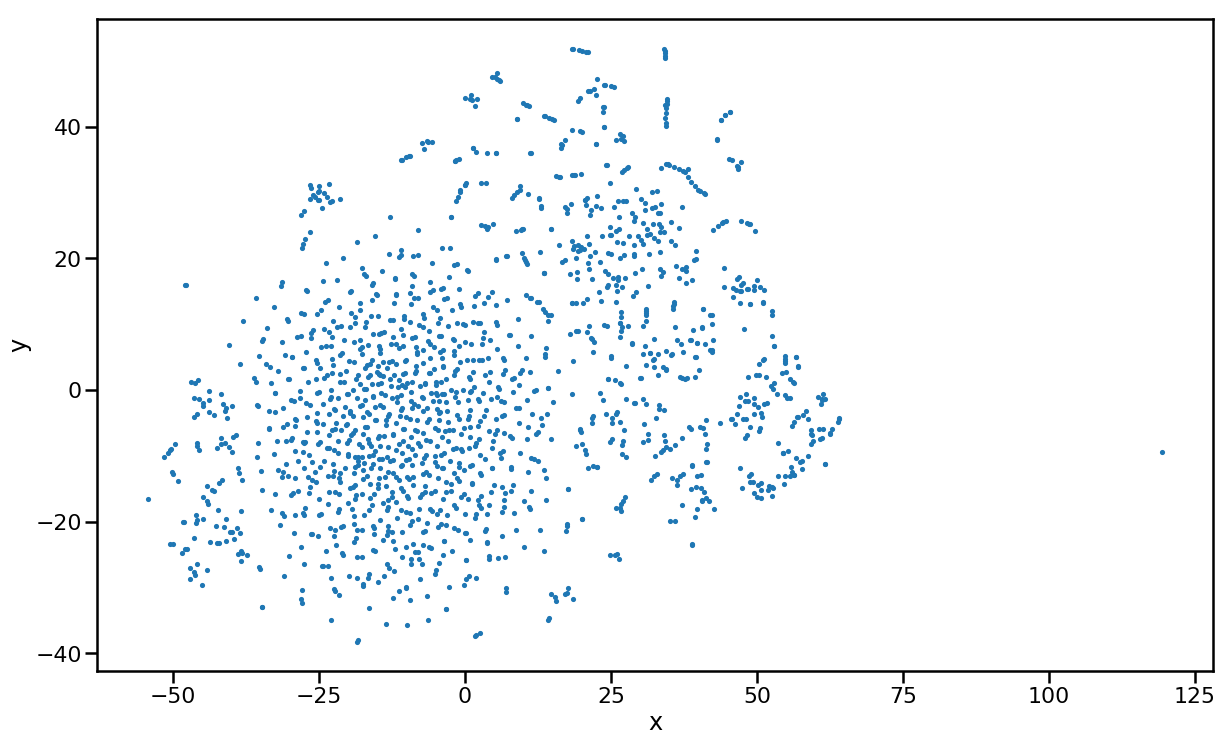

In [266]:
points.plot.scatter("x","y",s=10,figsize=(20,12))

In [267]:
def plot_region(x_bounds,y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slice.plot.scatter("x", "y",s=35,figsize=(20,12))
    for i, point in slice.iterrows():
        ax.text(point.x+0.005, point.y+0.005, point.word, fontsize=11)

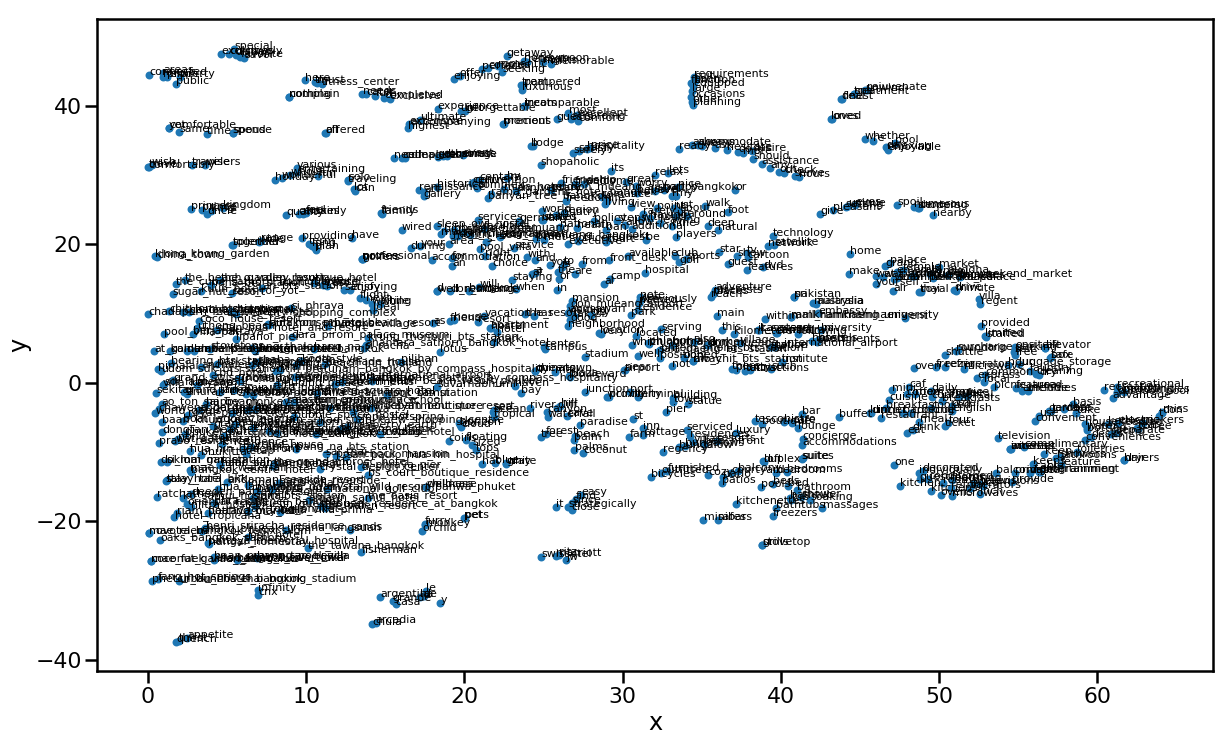

In [268]:
plot_region(x_bounds=(0,100), y_bounds=(-50,50))

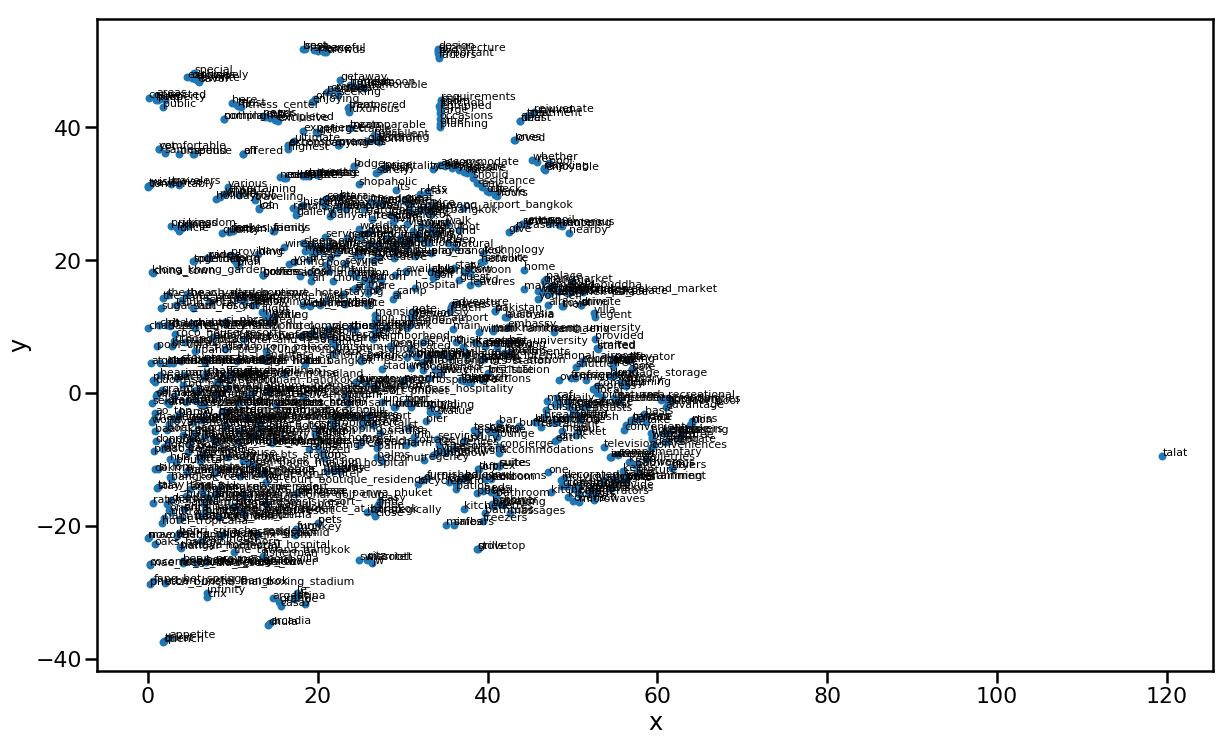

In [269]:
plot_region(x_bounds=(0, 2000), y_bounds=(-100,2000))

## Find similarity

In [471]:
hotel2vec.most_similar("Bangkok".lower())


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'villa', 0.7121477127075195),
 (u'regent', 0.6778704524040222),
 (u'minutes', 0.6739450097084045),
 (u'don_muang', 0.6521702408790588),
 (u'minute', 0.6323521137237549),
 (u'hotel', 0.6132586598396301),
 (u'drive', 0.5930410623550415),
 (u'caf', 0.5891667008399963),
 (u'lift', 0.5812899470329285),
 (u'car', 0.5588314533233643)]

In [472]:
hotel2vec_50_10.most_similar("Bangkok".lower())


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-03-06 10:21:10,410 : INFO : precomputing L2-norms of word weight vectors


[(u'hotel', 0.6686906814575195),
 (u'minutes', 0.6518415212631226),
 (u'allow', 0.6513987183570862),
 (u'and', 0.6302186846733093),
 (u'car', 0.6279315948486328),
 (u'with', 0.6278460621833801),
 (u'drive', 0.6245212554931641),
 (u'minute', 0.6113649606704712),
 (u'without', 0.6065735816955566),
 (u'a', 0.5988956689834595)]

In [420]:
hotel2vec_50_10_500iter.most_similar("Bangkok".lower())


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-03-05 21:35:30,269 : INFO : precomputing L2-norms of word weight vectors


[(u'hotel', 0.6686906814575195),
 (u'minutes', 0.6518415212631226),
 (u'allow', 0.6513987183570862),
 (u'and', 0.6302186846733093),
 (u'car', 0.6279315948486328),
 (u'with', 0.6278460621833801),
 (u'drive', 0.6245212554931641),
 (u'minute', 0.6113649606704712),
 (u'without', 0.6065735816955566),
 (u'a', 0.5988956689834595)]

In [340]:
hotel2vec_300.most_similar("Bangkok".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-03-05 20:51:53,834 : INFO : precomputing L2-norms of word weight vectors


[(u'don_muang', 0.5263683795928955),
 (u'hotel', 0.41174226999282837),
 (u'office', 0.4028930068016052),
 (u'miles', 0.36252179741859436),
 (u'desks', 0.35486358404159546),
 (u'minutes', 0.34726792573928833),
 (u'just', 0.3458721339702606),
 (u'guesthouse', 0.34500399231910706),
 (u'allow', 0.3424074351787567),
 (u'building', 0.3389786183834076)]

In [341]:
hotel2vec_number.most_similar("Bangkok".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-03-05 20:52:08,813 : INFO : precomputing L2-norms of word weight vectors


[(u'don_muang', 0.5775006413459778),
 (u'villa', 0.5585747361183167),
 (u'minutes', 0.5329896211624146),
 (u'minute', 0.5286729335784912),
 (u'regent', 0.5247888565063477),
 (u'drive', 0.4900273084640503),
 (u'lift', 0.46151578426361084),
 (u'hotel', 0.4544895887374878),
 (u'market', 0.4385499358177185),
 (u'car', 0.4376516342163086)]

In [469]:
hotel2vec.most_similar("IT_Square".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'kasetsart_university', 0.8508928418159485),
 (u'central', 0.798517644405365),
 (u'ramintra', 0.7807562947273254),
 (u'kilometers', 0.7676883935928345),
 (u'police', 0.7102197408676147),
 (u'within', 0.6964609622955322),
 (u'station', 0.6948980093002319),
 (u'following', 0.6663166284561157),
 (u'malaysia', 0.6438968777656555),
 (u'apartments', 0.6353309154510498)]

In [385]:
hotel2vec_50_10.most_similar("IT_Square".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'kasetsart_university', 0.8263366222381592),
 (u'kilometers', 0.8136006593704224),
 (u'central', 0.7629516124725342),
 (u'ramintra', 0.7283411026000977),
 (u'station', 0.6956437230110168),
 (u'apartments', 0.6704457998275757),
 (u'police', 0.666203498840332),
 (u'within', 0.6504793763160706),
 (u'following', 0.6405600905418396),
 (u'hotels', 0.6026745438575745)]

In [421]:
hotel2vec_50_10_500iter.most_similar("IT_Square".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'kasetsart_university', 0.8263366222381592),
 (u'kilometers', 0.8136006593704224),
 (u'central', 0.7629516124725342),
 (u'ramintra', 0.7283411026000977),
 (u'station', 0.6956437230110168),
 (u'apartments', 0.6704457998275757),
 (u'police', 0.666203498840332),
 (u'within', 0.6504793763160706),
 (u'following', 0.6405600905418396),
 (u'hotels', 0.6026745438575745)]

In [342]:
hotel2vec_300.most_similar("IT_Square".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'kasetsart_university', 0.6799156069755554),
 (u'kilometers', 0.6639461517333984),
 (u'central', 0.6112016439437866),
 (u'ramintra', 0.5793763995170593),
 (u'within', 0.5710224509239197),
 (u'vimanmek_palace', 0.49635496735572815),
 (u'dmk', 0.47715482115745544),
 (u'chatuchak_weekend_market', 0.47082361578941345),
 (u'following', 0.4655866026878357),
 (u'apartments', 0.4628654718399048)]

In [343]:
hotel2vec_number.most_similar("IT_Square".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'kasetsart_university', 0.7388209104537964),
 (u'kilometers', 0.6941394209861755),
 (u'central', 0.6843338012695312),
 (u'ramintra', 0.6720805764198303),
 (u'police', 0.6476098299026489),
 (u'royal', 0.5897205471992493),
 (u'within', 0.5884110927581787),
 (u'station', 0.5765060186386108),
 (u'thai', 0.5746811628341675),
 (u'proximity', 0.5652996897697449)]

In [468]:
hotel2vec.most_similar("International_Airport".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-03-06 10:20:35,811 : INFO : precomputing L2-norms of word weight vectors


KeyError: "word 'international_airport' not in vocabulary"

In [310]:
hotel2vec_300.most_similar("International_Airport".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'international_airport' not in vocabulary"

In [274]:
hotel2vec.most_similar("room_service")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'coffee_shop', 0.9116654396057129),
 (u'continental', 0.8359723091125488),
 (u'breakfasts', 0.8073813915252686),
 (u'hour', 0.7994641065597534),
 (u'caf', 0.7910733819007874),
 (u'daily', 0.7841206789016724),
 (u'breakfast', 0.7379637360572815),
 (u'am', 0.7368893623352051),
 (u'cuisine', 0.7250677347183228),
 (u'luggage_storage', 0.6954236030578613)]

In [386]:
hotel2vec_50_10.most_similar("room_service")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'coffee_shop', 0.9764662384986877),
 (u'caf', 0.8906188607215881),
 (u'continental', 0.8761749863624573),
 (u'cuisine', 0.8489918112754822),
 (u'restaurant', 0.8375298380851746),
 (u'dinner', 0.8372822999954224),
 (u'breakfasts', 0.8214817047119141),
 (u'lunch', 0.806307852268219),
 (u'am', 0.7789307832717896),
 (u'hour', 0.7750243544578552)]

In [311]:
hotel2vec_300.most_similar("room_service")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'coffee_shop', 0.8941947221755981),
 (u'hour', 0.6710511445999146),
 (u'continental', 0.6576651334762573),
 (u'breakfasts', 0.6534394025802612),
 (u'caf', 0.6426414251327515),
 (u'restaurant', 0.6233437061309814),
 (u'am', 0.5932230353355408),
 (u'cuisine', 0.5903884172439575),
 (u'daily', 0.5860456228256226),
 (u'featured', 0.559123694896698)]

In [344]:
hotel2vec_number.most_similar("room_service")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'continental', 0.8689358234405518),
 (u'coffee_shop', 0.8662907481193542),
 (u'caf', 0.8049470782279968),
 (u'breakfasts', 0.7969549298286438),
 (u'hour', 0.7796611785888672),
 (u'english', 0.713371992111206),
 (u'restaurant', 0.7089226841926575),
 (u'am', 0.7065865993499756),
 (u'daily', 0.7048704624176025),
 (u'cuisine', 0.7040393352508545)]

In [275]:
hotel2vec.most_similar("Kasetsart_University".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'it_square', 0.8645070791244507),
 (u'central', 0.7854214906692505),
 (u'ramintra', 0.7390963435173035),
 (u'kilometers', 0.7026901841163635),
 (u'following', 0.6665972471237183),
 (u'hotels', 0.6489603519439697),
 (u'police', 0.6354565620422363),
 (u'apartments', 0.6174027919769287),
 (u'chatuchak_weekend_market', 0.604561984539032),
 (u'station', 0.5953036546707153)]

In [388]:
hotel2vec_50_10.most_similar("Kasetsart_University".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'it_square', 0.8263366222381592),
 (u'kilometers', 0.7103980183601379),
 (u'central', 0.6790152192115784),
 (u'apartments', 0.6778643131256104),
 (u'ramintra', 0.6632766127586365),
 (u'phrom_phong_bts_station', 0.6394113898277283),
 (u'hostels', 0.6325003504753113),
 (u'station', 0.6003996729850769),
 (u'following', 0.5750210285186768),
 (u'sala_daeng_bts_station', 0.5730084180831909)]

In [312]:
hotel2vec_300.most_similar("Kasetsart_University".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'it_square', 0.6799156665802002),
 (u'central', 0.6312994956970215),
 (u'ramintra', 0.5936212539672852),
 (u'kilometers', 0.5327054858207703),
 (u'dmk', 0.5101295709609985),
 (u'mall_ramkhamhaeng', 0.5065885782241821),
 (u'apartments', 0.4864007830619812),
 (u'chatuchak_weekend_market', 0.47987717390060425),
 (u'condo', 0.45599955320358276),
 (u'emerald_buddha', 0.4554927349090576)]

In [345]:
hotel2vec_number.most_similar("Kasetsart_University".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'it_square', 0.7388209104537964),
 (u'central', 0.6649943590164185),
 (u'ramintra', 0.6266480088233948),
 (u'market', 0.6140718460083008),
 (u'police', 0.6093800067901611),
 (u'condo', 0.6061770915985107),
 (u'car', 0.605542778968811),
 (u'kilometers', 0.5933263301849365),
 (u'apartments', 0.5786912441253662),
 (u'drive', 0.5737913846969604)]

In [276]:
hotel2vec.most_similar("Phuket".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'krabi', 0.8188908696174622),
 (u'samui', 0.6847504377365112),
 (u'patong', 0.6629369258880615),
 (u'pattaya', 0.6214534044265747),
 (u'resorts', 0.6037310361862183),
 (u'khao', 0.5829887986183167),
 (u'ibiza', 0.5576843619346619),
 (u'hin', 0.5512009859085083),
 (u'regency', 0.5041863918304443),
 (u'suvarnabhumi', 0.5002363324165344)]

In [389]:
hotel2vec_50_10.most_similar("Phuket".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'krabi', 0.8188908696174622),
 (u'samui', 0.6847504377365112),
 (u'patong', 0.6629369258880615),
 (u'pattaya', 0.6214534044265747),
 (u'resorts', 0.6037310361862183),
 (u'khao', 0.5829887986183167),
 (u'ibiza', 0.5576843619346619),
 (u'hin', 0.5512009859085083),
 (u'satisfy', 0.504224419593811),
 (u'regency', 0.5041863918304443)]

In [313]:
hotel2vec_300.most_similar("Phuket".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'krabi', 0.6554592847824097),
 (u'samui', 0.5403432250022888),
 (u'pattaya', 0.5342226028442383),
 (u'khao', 0.4868389964103699),
 (u'patong', 0.4652283191680908),
 (u'hin', 0.42629945278167725),
 (u'resorts', 0.3812099099159241),
 (u'yai', 0.37878960371017456),
 (u'nakhon', 0.3757421672344208),
 (u'chonburi', 0.342098206281662)]

In [346]:
hotel2vec_number.most_similar("Phuket".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'golf', 0.6091367602348328),
 (u'court', 0.4653467833995819),
 (u'bersama', 0.4638092517852783),
 (u'my', 0.42512479424476624),
 (u'appetite', 0.41153109073638916),
 (u'm', 0.3895528316497803),
 (u'v', 0.31979262828826904),
 (u'including', 0.31677860021591187),
 (u'include', 0.3160892426967621),
 (u'opportunities', 0.31556665897369385)]

In [277]:
hotel2vec.similar_by_word("near")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'airport', 0.757114052772522),
 (u'inn', 0.65962153673172),
 (u'don_mueang_international_airport', 0.6581777930259705),
 (u'well', 0.5953010320663452),
 (u'dmk', 0.586973249912262),
 (u'sala_daeng_bts_station', 0.5646565556526184),
 (u'hotel', 0.563890814781189),
 (u'beach', 0.5588935017585754),
 (u'phrom_phong_bts_station', 0.5586064457893372),
 (u'park', 0.5515755414962769)]

In [390]:
hotel2vec_50_10.similar_by_word("near")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'airport', 0.7455528974533081),
 (u'don_mueang_international_airport', 0.7292960286140442),
 (u'dmk', 0.7120150923728943),
 (u'hotel', 0.6196889877319336),
 (u'kilometers', 0.5982018709182739),
 (u'well', 0.593989908695221),
 (u'only', 0.5939230918884277),
 (u'also', 0.5910187363624573),
 (u'ideal', 0.5738158226013184),
 (u'located', 0.5689125657081604)]

In [314]:
hotel2vec_300.similar_by_word("near")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'airport', 0.6334060430526733),
 (u'don_mueang_international_airport', 0.5560151934623718),
 (u'dmk', 0.49324560165405273),
 (u'only', 0.4887692928314209),
 (u'also', 0.48129260540008545),
 (u'well', 0.4612963795661926),
 (u'mo_chit_bts_station', 0.4451846778392792),
 (u'hotel', 0.43597015738487244),
 (u'waiting', 0.4339590072631836),
 (u'kilometers', 0.43373382091522217)]

In [347]:
hotel2vec_number.similar_by_word("near")

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'airport', 0.6515418291091919),
 (u'don_mueang_international_airport', 0.5569671392440796),
 (u'well', 0.5093034505844116),
 (u'only', 0.5030028820037842),
 (u'also', 0.5019452571868896),
 (u'dmk', 0.4928044080734253),
 (u'mo_chit_bts_station', 0.4878407120704651),
 (u'sala_daeng_bts_station', 0.4836251735687256),
 (u'phrom_phong_bts_station', 0.4760778546333313),
 (u'thung_maha_mek', 0.4735587239265442)]

In [278]:
hotel2vec.similar_by_word("WiFi".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'property', 0.7532224655151367),
 (u'areas', 0.689681351184845),
 (u'sure', 0.6660940647125244),
 (u'dishes', 0.6485171914100647),
 (u'savor', 0.6415386199951172),
 (u'help', 0.640691339969635),
 (u'outstanding', 0.6333634257316589),
 (u'cuisines', 0.6274214386940002),
 (u'i', 0.6261616349220276),
 (u'favorite', 0.6257742047309875)]

In [391]:
hotel2vec_50_10.similar_by_word("WiFi".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'property', 0.9064799547195435),
 (u'help', 0.8680188059806824),
 (u'areas', 0.7254765033721924),
 (u'favorite', 0.6824386715888977),
 (u'savor', 0.6785324215888977),
 (u'dishes', 0.6621673107147217),
 (u'cuisines', 0.6534022092819214),
 (u'comfort', 0.6441880464553833),
 (u'public', 0.6412482261657715),
 (u'family', 0.6325515508651733)]

In [315]:
hotel2vec_300.similar_by_word("WiFi".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'property', 0.6138045191764832),
 (u'help', 0.5545387268066406),
 (u'areas', 0.5454027056694031),
 (u'dishes', 0.5387824773788452),
 (u'cuisines', 0.5316739678382874),
 (u'favorite', 0.5234544277191162),
 (u'savor', 0.5191605091094971),
 (u'accommodate', 0.4826652705669403),
 (u'public', 0.4819079041481018),
 (u'exclusively', 0.4682239592075348)]

In [348]:
hotel2vec_number.similar_by_word("WiFi".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'property', 0.627922773361206),
 (u'areas', 0.575302243232727),
 (u'help', 0.5732396841049194),
 (u'dishes', 0.5538973212242126),
 (u'favorite', 0.5488030314445496),
 (u'cuisines', 0.5461959838867188),
 (u'savor', 0.5393167734146118),
 (u'public', 0.5121226906776428),
 (u'accommodate', 0.5080562233924866),
 (u'exclusively', 0.49199697375297546)]

In [279]:
hotel2vec.similar_by_word("Airport".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'near', 0.757114052772522),
 (u'waiting', 0.7263479232788086),
 (u'office', 0.5851593613624573),
 (u'next', 0.5800415277481079),
 (u'inn', 0.5748487114906311),
 (u'ideal', 0.569052517414093),
 (u'don_mueang_international_airport', 0.5501310229301453),
 (u'port', 0.5495341420173645),
 (u'station', 0.5494598150253296),
 (u'sala_daeng_bts_station', 0.5352652668952942)]

In [392]:
hotel2vec_50_10.similar_by_word("Airport".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'near', 0.7455530166625977),
 (u'waiting', 0.7216796278953552),
 (u'ideal', 0.6203997731208801),
 (u'next', 0.6152597665786743),
 (u'flight', 0.5578991174697876),
 (u'hotel', 0.5347704291343689),
 (u'don_mueang_international_airport', 0.5300017595291138),
 (u'well', 0.5131352543830872),
 (u'dmk', 0.5066954493522644),
 (u'policy', 0.49730709195137024)]

In [316]:
hotel2vec_300.similar_by_word("Airport".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'near', 0.6334060430526733),
 (u'waiting', 0.6153743267059326),
 (u'next', 0.5002350211143494),
 (u'ideal', 0.475594162940979),
 (u'hotel', 0.45754024386405945),
 (u'don_mueang_international_airport', 0.4193892776966095),
 (u'dmk', 0.41339442133903503),
 (u'phrom_phong_bts_station', 0.4132753610610962),
 (u'well', 0.40504229068756104),
 (u'phlabphla', 0.40079814195632935)]

In [349]:
hotel2vec_number.similar_by_word("Airport".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'near', 0.6515418291091919),
 (u'waiting', 0.6418971419334412),
 (u'next', 0.5330125689506531),
 (u'shuttle', 0.515143871307373),
 (u'roundtrip', 0.5112771391868591),
 (u'ideal', 0.5074974298477173),
 (u'refrigerator', 0.49897366762161255),
 (u'hotel', 0.49190565943717957),
 (u'park', 0.4757968783378601),
 (u'surcharge', 0.4722541868686676)]

In [317]:
hotel2vec.similar_by_word("spa".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'treatment', 0.8894541263580322),
 (u'unwind', 0.8304634690284729),
 (u'deal', 0.7701583504676819),
 (u'finest', 0.7680665254592896),
 (u'rejuvenate', 0.7641175389289856),
 (u'guestrooms', 0.6125805974006653),
 (u'golf', 0.6051614284515381),
 (u'ones', 0.5436419248580933),
 (u'yourself', 0.5248085260391235),
 (u'golfers', 0.5199235677719116)]

In [393]:
hotel2vec_50_10.similar_by_word("spa".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'treatment', 0.9582748413085938),
 (u'unwind', 0.9467130303382874),
 (u'deal', 0.9375593662261963),
 (u'finest', 0.921581506729126),
 (u'rejuvenate', 0.9182718396186829),
 (u'ones', 0.808208703994751),
 (u'loved', 0.6391546130180359),
 (u'pool', 0.5535215139389038),
 (u're', 0.5426928400993347),
 (u'argentina', 0.5279343724250793)]

In [318]:
hotel2vec_300.similar_by_word("spa".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'treatment', 0.598905086517334),
 (u'unwind', 0.544102668762207),
 (u'rejuvenate', 0.5290390849113464),
 (u'finest', 0.5109617710113525),
 (u'deal', 0.4955791234970093),
 (u'yourself', 0.3869576156139374),
 (u'ones', 0.3621456027030945),
 (u'rooms', 0.33544641733169556),
 (u'pools', 0.3226622939109802),
 (u'vacation', 0.3162997364997864)]

In [350]:
hotel2vec_number.similar_by_word("spa".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'treatment', 0.9455406665802002),
 (u'unwind', 0.9098449349403381),
 (u'finest', 0.892301619052887),
 (u'rejuvenate', 0.8674742579460144),
 (u'deal', 0.856858491897583),
 (u'ones', 0.5771458148956299),
 (u'yourself', 0.5648503303527832),
 (u'best', 0.5592072606086731),
 (u'decorated', 0.5188796520233154),
 (u'featuring', 0.5141599774360657)]

In [281]:
hotel2vec.similar_by_word("coffee".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'tea', 0.940730631351471),
 (u'makers', 0.8505187630653381),
 (u'bottled', 0.8139366507530212),
 (u'sitting', 0.8134122490882874),
 (u'drink', 0.8110491633415222),
 (u'separate', 0.779100775718689),
 (u'water', 0.7753753066062927),
 (u'conveniences', 0.7554230093955994),
 (u'electric', 0.7207562327384949),
 (u't', 0.7177690267562866)]

In [394]:
hotel2vec_50_10.similar_by_word("coffee".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'tea', 0.9661718606948853),
 (u'makers', 0.9439584016799927),
 (u'sitting', 0.8759799599647522),
 (u't', 0.8499858379364014),
 (u'don', 0.8498067259788513),
 (u'separate', 0.8361129760742188),
 (u'miss', 0.8337743282318115),
 (u'dryers', 0.7911969423294067),
 (u'hair', 0.7900280952453613),
 (u'opportunities', 0.787898063659668)]

In [319]:
hotel2vec_300.similar_by_word("coffee".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'tea', 0.7944289445877075),
 (u'makers', 0.6297069191932678),
 (u'sitting', 0.566946804523468),
 (u'drink', 0.559377908706665),
 (u'bottled', 0.4854060411453247),
 (u'separate', 0.48335355520248413),
 (u'don', 0.4601641595363617),
 (u'water', 0.4505344331264496),
 (u't', 0.44857221841812134),
 (u'miss', 0.4420357346534729)]

In [351]:
hotel2vec_number.similar_by_word("coffee".lower())

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[(u'tea', 0.9601176977157593),
 (u'makers', 0.9469466805458069),
 (u'don', 0.9031016826629639),
 (u'sitting', 0.9010291695594788),
 (u'separate', 0.8943072557449341),
 (u't', 0.8921347856521606),
 (u'miss', 0.8456693887710571),
 (u'electric', 0.8385105729103088),
 (u'kettles', 0.7912964820861816),
 (u'bottled', 0.7857663631439209)]

In [282]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = hotel2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [285]:
nearest_similarity_cosmul("Kasetsart_University".lower(), "Bangkok".lower(), "IT_Square".lower())
#nearest_similarity_cosmul("Phuket".lower(), "Patong".lower(), "Lipa".lower())

kasetsart_university is related to bangkok, as central is related to it_square


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


u'central'

In [213]:
hotel2vec = w2v.Word2Vec.load(os.path.join("trained", filename))

2019-03-05 19:10:51,047 : INFO : loading Word2Vec object from trained/hotel2vec_desc-50.w2v
2019-03-05 19:10:51,065 : INFO : loading vocabulary recursively from trained/hotel2vec_desc-50.w2v.vocabulary.* with mmap=None
2019-03-05 19:10:51,068 : INFO : loading wv recursively from trained/hotel2vec_desc-50.w2v.wv.* with mmap=None
2019-03-05 19:10:51,071 : INFO : setting ignored attribute vectors_norm to None
2019-03-05 19:10:51,078 : INFO : loading trainables recursively from trained/hotel2vec_desc-50.w2v.trainables.* with mmap=None
2019-03-05 19:10:51,079 : INFO : setting ignored attribute cum_table to None
2019-03-05 19:10:51,081 : INFO : loaded trained/hotel2vec_desc-50.w2v


In [214]:
vector = hotel2vec.wv['Bangkok'.lower()] 
vector

array([ 5.01814127e-01,  1.24848694e-01, -1.06363647e-01,  4.41312045e-01,
        5.64989030e-01, -8.45437467e-01, -3.09724629e-01,  2.55828261e-01,
        5.69774210e-01, -7.81637967e-01, -2.49894604e-01,  5.55965960e-01,
       -2.91103959e-01, -6.86506828e-05, -1.80058345e-01,  8.64606023e-01,
       -2.34000478e-02,  2.46387839e-01, -8.15863684e-02, -2.76500359e-02,
        4.09238674e-02,  1.88057363e-01,  2.04635754e-01, -3.16337347e-01,
       -8.79507244e-01, -4.46897417e-01,  9.41037774e-01,  4.68736887e-01,
       -3.25342745e-01, -1.25858128e-01,  2.34876633e+00,  5.04345715e-01,
        5.45908473e-02, -8.58691275e-01, -2.67689288e-01,  4.37887967e-01,
        5.83725095e-01, -3.66901815e-01, -2.04370111e-01,  6.18247271e-01,
        1.42669901e-01, -6.63437098e-02,  1.40131608e-01, -2.90437639e-01,
        1.55150250e-01, -2.83431023e-01, -4.72701460e-01, -9.44789171e-01,
        8.09644233e-04, -1.08007334e-01], dtype=float32)

In [426]:
len(hotel2vec.wv['Bangkok'.lower()])

50

#### Save to txt file as glove.txt

In [467]:
filename2 = 'hotel_w2v-50.txt'
filename3 = 'hotel_w2v-300.txt'
filename4 = 'hotel_w2v-num.txt'
hotel2vec.wv.save_word2vec_format(os.path.join("trained", filename2))
hotel2vec_300.wv.save_word2vec_format(os.path.join("trained", filename3))
hotel2vec_number.wv.save_word2vec_format(os.path.join("trained", filename4))


2019-03-06 10:19:32,760 : INFO : storing 1844x50 projection weights into trained/hotel_w2v-50.txt
2019-03-06 10:19:32,876 : INFO : storing 1688x300 projection weights into trained/hotel_w2v-300.txt
2019-03-06 10:19:33,319 : INFO : storing 1688x300 projection weights into trained/hotel_w2v-num.txt


In [ ]:
from gensim.models import KeyedVectors

In [ ]:
filename2 = 'hotel_w2v.txt'
tmp_file_name = '.tmp.txt'
word2vec_model_file_name = 'trained/'+filename2
glove_output = 'hotel_w2v_glove.txt'
f_out = open(glove_output,"w")
for _ in range(2):
    try:
        with open(word2vec_model_file_name) as word2vec_model_file:
            i = 0
            for r in word2vec_model_file:
                if 0 < i:
                    if i < 5:
                        print(r.strip())
                    #print(r.strip())
                    f_out.write(r.strip())
                    

                i += 1

        break
    except UnicodeDecodeError:
        word2vec_model_file_name = tmp_file_name
        KeyedVectors.load_word2vec_format(args.word2vec, binary=True).save_word2vec_format(word2vec_model_file_name)

## Use glove  instead of word2vec

https://medium.com/@japneet121/word-vectorization-using-glove-76919685ee0b

In [123]:
#importing the glove library
from glove import Corpus, Glove
# creating a corpus object
corpus = Corpus() 

In [124]:
#training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(sentences, window=10)

In [125]:
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
glove = Glove(no_components=50, learning_rate=0.05)

In [127]:
glove.fit(corpus.matrix, epochs=50, no_threads=4, verbose=True)

Performing 50 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


In [128]:
glove.add_dictionary(corpus.dictionary)
glove.save('hotel_glove.model')

In [129]:
myglove = glove.load('hotel_glove.model')

In [130]:
myglove.dictionary['Bangkok'] 
 

4

In [131]:
glove_array = myglove.word_vectors[myglove.dictionary['Bangkok'] ]
len(myglove.dictionary)

5140

In [132]:
myglove.word_vectors[myglove.dictionary['Kasetsart_University'] ]

array([ 0.02317198, -0.00400988,  0.27154753,  0.34258774,  0.29669764,
       -0.10169492,  0.17833744, -0.18434466,  0.14687584, -0.17312642,
       -0.02744937,  0.14758853,  0.15490986, -0.05294573,  0.17673435,
        0.02530975,  0.02349327,  0.38147104, -0.19393674,  0.14261699,
       -0.0580615 , -0.16821352,  0.11805088, -0.18006032, -0.21644925,
       -0.19275376, -0.09107742,  0.05330119, -0.0957203 ,  0.36793007,
       -0.01663738,  0.18041227, -0.09324734, -0.12750675, -0.13404956,
       -0.02960633,  0.03554844, -0.16998832, -0.03553023,  0.28192364,
        0.02012091, -0.13314615,  0.17112599,  0.01267713, -0.01753263,
       -0.01080939, -0.17188071, -0.00075066,  0.01394742, -0.26040992])

In [133]:
glove_array

array([-0.56522047,  0.010037  , -0.8040945 ,  0.49223253, -0.18845363,
        0.3199197 , -0.22571346, -0.06825335, -0.39972866, -0.28207984,
        0.32815257, -0.30993775, -0.1290981 ,  0.01082492, -0.2076202 ,
       -0.55255747,  0.08242027,  0.05467188,  0.37632727,  0.16025341,
        0.50056302,  0.47248817,  0.23390125, -0.36294925, -0.40547435,
        0.55180477, -0.08885894,  0.21196311, -0.13934884, -0.27369967,
       -0.4381301 ,  0.00270126,  0.22864129,  0.02581323, -0.71066552,
        0.30774797,  0.45864403,  0.09412277, -0.10314704, -0.3448774 ,
        0.3278901 ,  0.2478648 , -0.28922502, -0.11657391, -0.15663041,
        0.22560216,  0.07830093,  0.24151882, -0.15769802, -0.21193433])

In [134]:
#save to txt file

filename3 = 'hotel_glove.txt'
f = open(filename3,"wt")
#print(myglove.dictionary)
for k in myglove.dictionary:
     
    f.write(k)
    f.write(' ')
    v = myglove.word_vectors[myglove.dictionary[k] ]
    
     
    for i in v:
        f.write('%f'%(i))
        f.write(' ')
    f.write('\n')
    
f.close()
    

In [135]:
!ls

1512.01712v1 (1).pdf             glove-python
Abstractive-Summarization        glove.6B.100d.txt
Archive                          glove.6B.200d.txt
Archive.zip                      glove.6B.300d.txt
Bangkok.csv                      glove.6B.50d.txt
ChiangMai.csv                    glove.6B.zip
Chiang_Mai.csv                   glove_hotel2vec_desc.w2v.txt
Chonburi.csv                     hotel_glove.model
Consumer_Complaints.csv          hotel_glove.txt
Desc and Nearby                  hotel_w2v_glove.txt
Doc2Vec-Consumer-Complaint.ipynb myglove.txt
Extractive-Text-Summarization    numberbatch-en-17.02.txt.gz
Krabi.csv                        recurrent-neural-networks
Phuket.csv                       test_word_embeddings.ipynb
PrachuapKhiriKhan.csv            train.ipynb
Reviews.csv                      trained
SuratTani.csv                    training
SuratThani.csv                   traveloka
__MACOSX                         vocabulary-embedding.ipynb
classify_complaint.ipynb         w